# Predicting hospital readmission within 30 days of discharge for diabetic patients

In this project I aim to predict which diabetic patients will be readmitted within 30 days of discharge and to determine the factors that lead to hospital readmissions.  Medicare does not reimburse hospitals for patient readmissions that happen within 30 days of a previous discharge, making it a priority for hospitals to prevent readmissions also from a financial standpoint. Building this model benefits both patients and hospitals. By identifying specific patients more likely to be readmitted, and more broadly, which factors lead to readmission within 30 days of discharge, the hospitals could implement a variety of strategies to educate patients, provide them with resources, and appropriate outpatient follow-up with a primary care provider. Patients benefit from improved health outcomes and avoiding preventable hospital stays. The target of this project is UPMC hospitals. The best supervised machine learning model generated in this project was a **random forests model**. 

In [1]:
# Let's load in our libraries:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import imblearn.over_sampling

from sklearn.model_selection import PredefinedSplit # To deal with data bleeding


In [2]:
# This configures jupyter for rendering plots 
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Load the data
diabetic_data = pd.read_csv('diabetic_data.csv')

In [4]:
diabetic_data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

## 1 - EDA

In [6]:
diabetic_data.replace('?', np.NaN,inplace=True) 

Create the target column: readmitted_binary_target

In [7]:
def makes_target_binary(row):
    if row == '<30':
        return 1
    else:
        return 0
    
diabetic_data['readmitted_binary_target'] =  diabetic_data['readmitted'].apply(makes_target_binary)   

Check for class imbalance:

0    0.888401
1    0.111599
Name: readmitted_binary_target, dtype: float64


<AxesSubplot:>

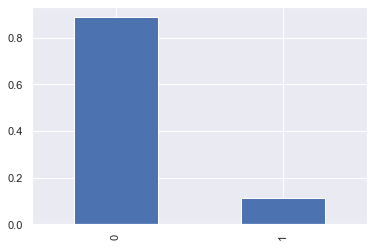

In [8]:
target_values = diabetic_data.readmitted_binary_target.value_counts(normalize=True) 
print(target_values)
target_values.plot(kind='bar')

We do have class imbalance

Check now if some patients were admitted to the hospital more than once (if they appear on more than one row.

This is relevant because we want to avoid data bleeding

In [9]:
# Unique values for.
number_unique_patients = diabetic_data['patient_nbr'].nunique()
total_admissions = len(diabetic_data)
print(f'number of unique patients: {number_unique_patients}')
print(f'total number of admissions: {total_admissions}')

number of unique patients: 71518
total number of admissions: 101766


We need to control for this to avoid data bleeding, data from the same patient cannot be both in the training set and in the validation or test sets.

For the baseline model, I will use a single training/validation split scheme.

In [19]:
def get_trainValidation80_test20_split(df,test_size=.2,seed=42):
    
    '''
    This function makes an 80/20 (training + validation)/test split. This means that 80% of the data will be used for 10-fold cross-validation, 
    and the remaining 20% will be used for testing the model. The seed argument is introduced for reproducibility (that is,
    every time that this function is called, it will generate the same split). 
    This split is performed at the patient ID level, because some patients appear in more than one row in the dataset, we want to avoid
    data bleeding.
    
    '''
    
    rs = np.random.RandomState(seed)

    # Finds unique patients:
    total_patients = df['patient_nbr'].unique() 
    # Chooses 20% of patients for the testing set.
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)
    # The remaining patients are selected for he training-validation set.
    training_validation_set= df[~df['patient_nbr'].isin(test_patients)]
    test_set = df[df['patient_nbr'].isin(test_patients)] 

    return training_validation_set, test_set

In [20]:
def prepares_dataset_for_current_model(df,features_model):
    final_features = ['patient_nbr','readmitted_binary_target']
    final_features.extend(features_model)
    df_model = df[final_features].copy()
    df_model.columns = final_features
    return df_model

In [21]:
def get_single_split_training_validation(df,features_model,test_size=.25, seed=40):
    
    # It is a 75/25 split
    df = prepares_dataset_for_current_model(df,features_model)
    rs = np.random.RandomState(seed)
    
    total_patients = df['patient_nbr'].unique() 
    validation_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)

    df_train = df[~df['patient_nbr'].isin(validation_patients)]
    df_val = df[df['patient_nbr'].isin(validation_patients)] 

    y_train, y_val = df_train['readmitted_binary_target'], df_val['readmitted_binary_target']
    
    X_train = df_train.drop(['readmitted_binary_target'],axis=1) 
    X_val = df_val.drop(['readmitted_binary_target'],axis=1)

    return X_train, X_val, y_train, y_val,df # we output 'df' as well for EDA plots.

In [22]:
# Generate the splits for 10-fold CV (outputs a numpy array):
def split_given_size(a, size):
    return np.split(a, np.arange(size,len(a),size))

In [23]:
# Generates labels for 10 predetermined splits for 10-fold cross-validation, avoiding data bleeding.

def split_labels_10CV_no_bleeding(df,random_seed = 42):
        
    # Extract unique patients:
    total_unique_patients = df['patient_nbr'].unique() 
    # Set a random seed and shuffle the unique patients:
    np.random.seed(random_seed) 
    np.random.shuffle(total_unique_patients) 

    # Find the length of each of the ten splits:
    len_split = round(np.floor(len(total_unique_patients)/10)) # = 5720
    # Generate the splits (outputs a numpy array):
    splits = split_given_size(total_unique_patients,len_split)
    # Concatenates the remainder observations into the last split (into the index 9th, it's the 10th), and then delete the splits[10]
    splits[9] = np.concatenate([splits[9], splits[10]])
    del splits[10]

    # Create a list, with the split number for each observation in X_tr['patient_nbr']
    test_fold =[]
    for i,encounter in enumerate(df['patient_nbr']): # Iterates through all observation, on the patient ID column (some patients will appear more than once).
        for numFold in range(len(splits)): # for each split (there are ten) store its index.
            if encounter in splits[numFold]: # if the patient ID appears in the current fold, then append the current fold number.
                test_fold.append(numFold)
    
    test_fold = np.array(test_fold)
    ps = PredefinedSplit(test_fold) 
    print(f'{ps.get_n_splits()} splits have been successfully generated')

    return ps

In [24]:
def pairplot_features(df, sample_size=500):
    sample = (df.drop(['patient_nbr'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='readmitted_binary_target', plot_kws=dict(alpha=.3, edgecolor='none'))

In [25]:
# Testing - ready to go.

In [26]:
# Precision recall-curve

def plots_precision_recall_curve(model,X_val,y_val):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1])
    plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as fraud)');
    plt.title('Precision and Recall Curves');
    

In [29]:
# # ROC curve

# fpr, tpr, thresholds = roc_curve(y_val, forest_balanced.predict_proba(X_val)[:,1])

# plt.plot(fpr, tpr,lw=2)
# plt.plot([0,1],[0,1],c='violet',ls='--')
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])


# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve for fraud problem');
# print("ROC AUC score = ", roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))

In [30]:
# # Confusion matrix, plot it.

# # Print confusion matrix for logistic regression
# logit_confusion = confusion_matrix(y_val, forest_balanced.predict(X_val))
# sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Logistic regression confusion matrix');


In [ ]:
# Run model - logistic regression

Generate the an 80/20 training and validation / test split. This will only be performed once:

In [27]:
training_validation_set,test_set =  get_trainValidation80_test20_split(diabetic_data)

In [53]:
predetermined_10CV_splits_noBleeding = split_labels_10CV_no_bleeding(training_validation_set,random_seed = 42)

10 splits have been successfully generated


# (1) Baseline model: Logistic regression:

### All numerical features:

## Single Split

In [68]:
features_model_01 = ['num_procedures','num_medications','number_diagnoses'] # Add all numerical
X_train, X_val, y_train, y_val, dataset_features_selected = get_single_split_training_validation(training_validation_set,features_model_01)

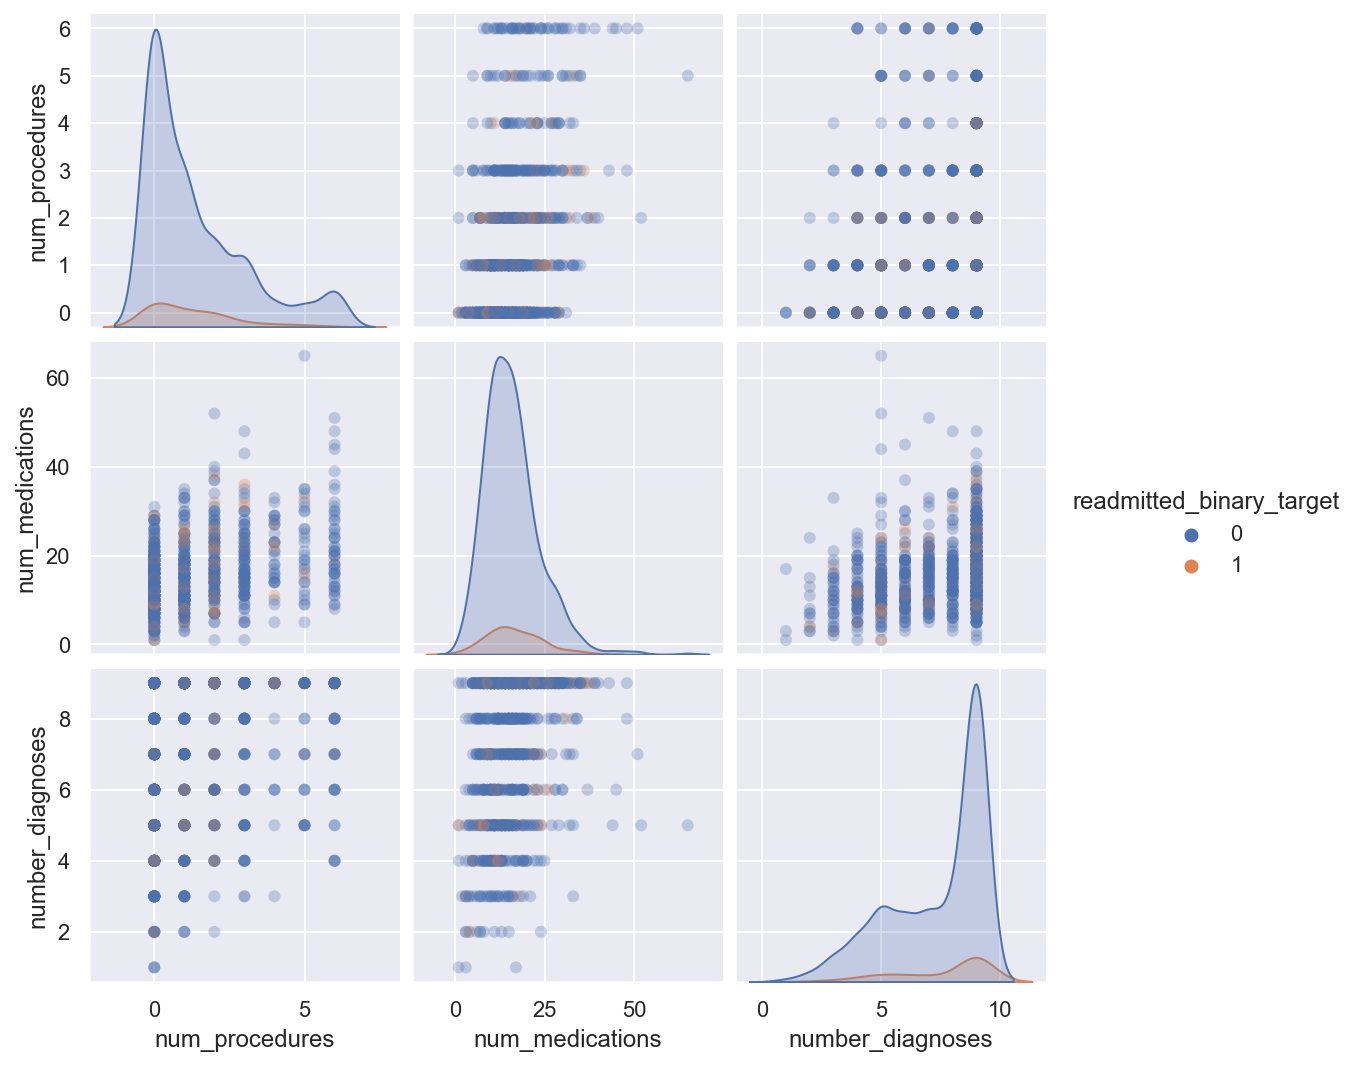

In [73]:
# Plot features
pairplot_features(dataset_features_selected)
del dataset_features_selected

In [ ]:
lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
print(lr.score(X_test, y_test)) # Because we are working with imbalanced data.

## 10 fold-cross validation

# Random forests

In [154]:
target = ['readmitted_binary_target'];

###  All numerical features: cross validation / 10-fold CV / imbalancing: weighting at training

In [155]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

F1 training mean 10-fold cv: 0.942 +- 0.001
F1 validation mean 10-fold cv: 0.042 +- 0.006
ROC-AUC mean 10-fold cv: 0.573 +- 0.007


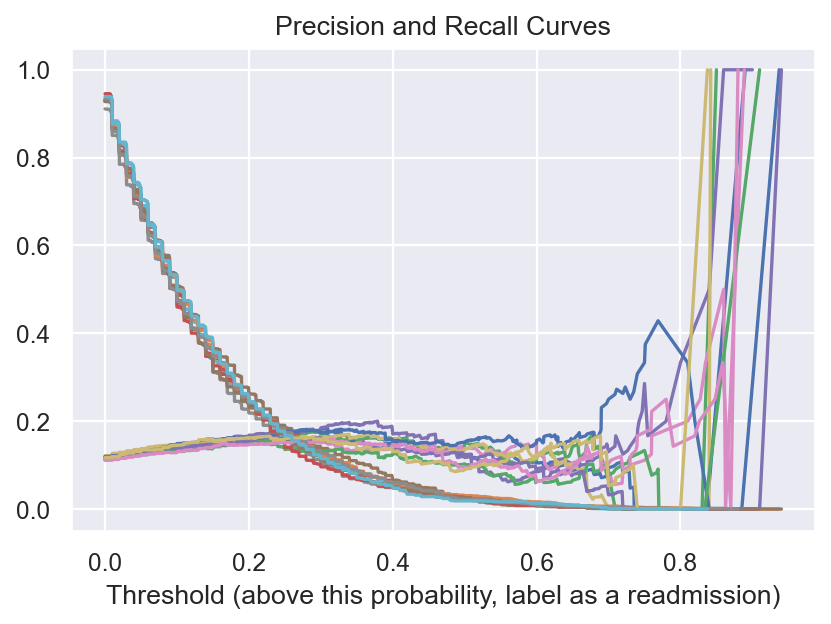

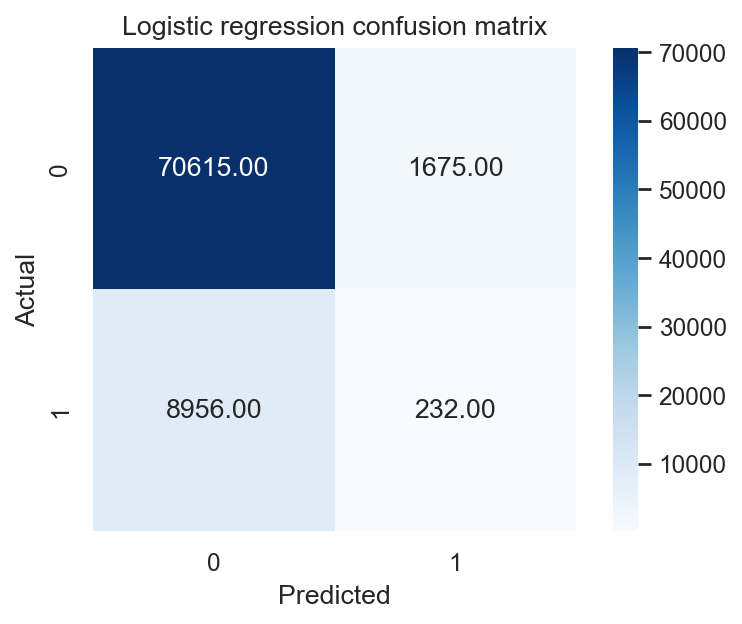

In [167]:
X_train = np.array(training_validation_set[features_all_numerical])
y_train = np.array(training_validation_set[target])

cv_F1_training = []
cv_ROC_AUC = []
cv_F1_validation = []

    
plt.figure(dpi=80)
ct = 1
for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
    X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
    X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
    
    forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
    forest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
    
    cv_F1_training.append(f1_score(y_train_fold, forest_balanced.predict(X_train_fold)).round(3))
    cv_F1_validation.append(f1_score(y_val_fold, forest_balanced.predict(X_val_fold)).round(3))
    cv_ROC_AUC.append(roc_auc_score(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1]).round(3))
    
    # Recall-Precision curve
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
    plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
    # plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');
    
    # Confusion matrix
    confusion = confusion_matrix(y_val_fold, forest_balanced.predict(X_val_fold))
    if ct ==1:
        confusion_final = confusion
    else:
        confusion_final +=confusion
    ct+=1
        
      
print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

plt.figure(dpi=80)
# Print confusion matrix for logistic regression
sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');



Try removing different numerical features until finding the best ones:

In [170]:
global target
global predetermined_10CV_splits_noBleeding
global training_validation_set

In [476]:
def random_forests_weightsBalanced(features_all_numerical,training_validation_set):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

        forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        forest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        cv_F1_training.append(f1_score(y_train_fold, forest_balanced.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, forest_balanced.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1]).round(3))

        # Recall-Precision curve
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1])
        plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, forest_balanced.predict(X_val_fold))
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1


    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    plt.figure(dpi=80)
    # Print confusion matrix for logistic regression
    sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');




Checking different numerical features for random forests, to determine the best features:

F1 training mean 10-fold cv: 0.942 +- 0.001
F1 validation mean 10-fold cv: 0.042 +- 0.006
ROC-AUC mean 10-fold cv: 0.573 +- 0.007


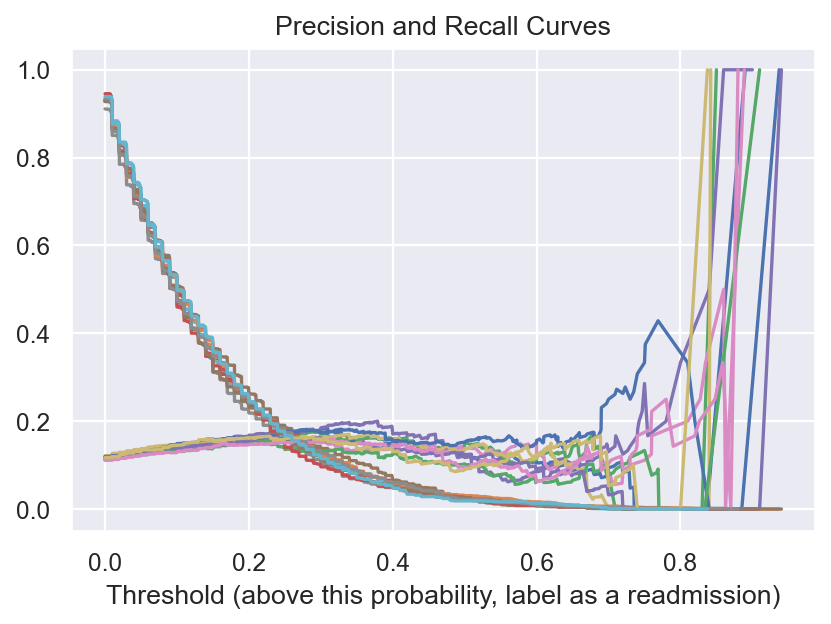

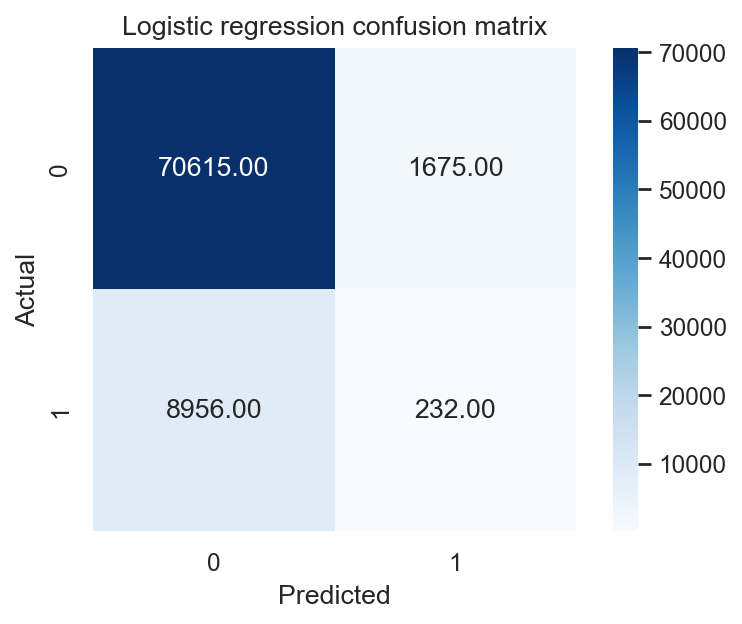

In [171]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.850 +- 0.001
F1 validation mean 10-fold cv: 0.072 +- 0.011
ROC-AUC mean 10-fold cv: 0.564 +- 0.010


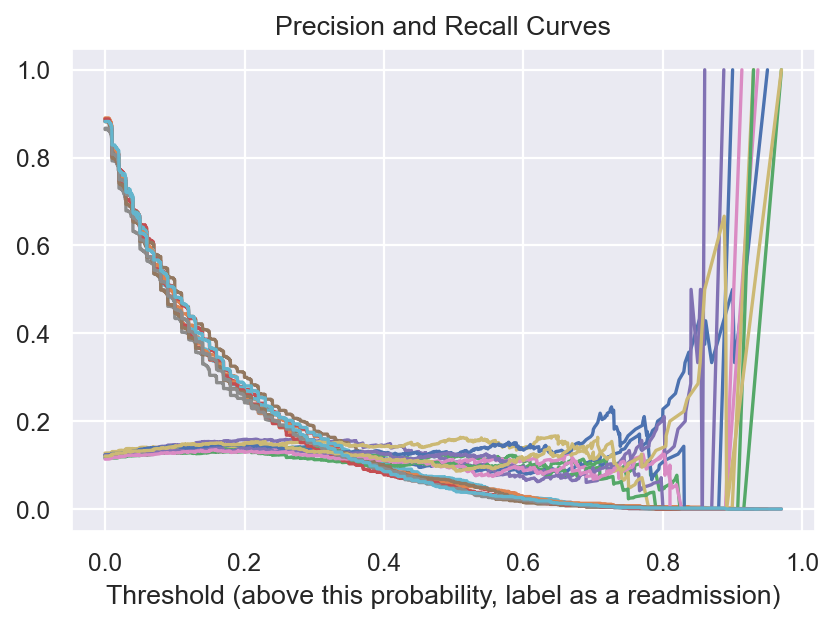

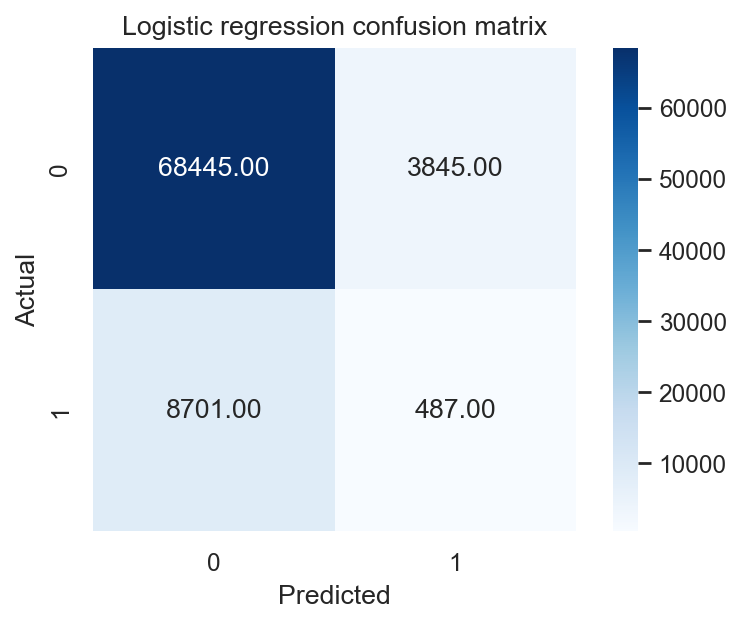

In [172]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.753 +- 0.002
F1 validation mean 10-fold cv: 0.092 +- 0.012
ROC-AUC mean 10-fold cv: 0.526 +- 0.010


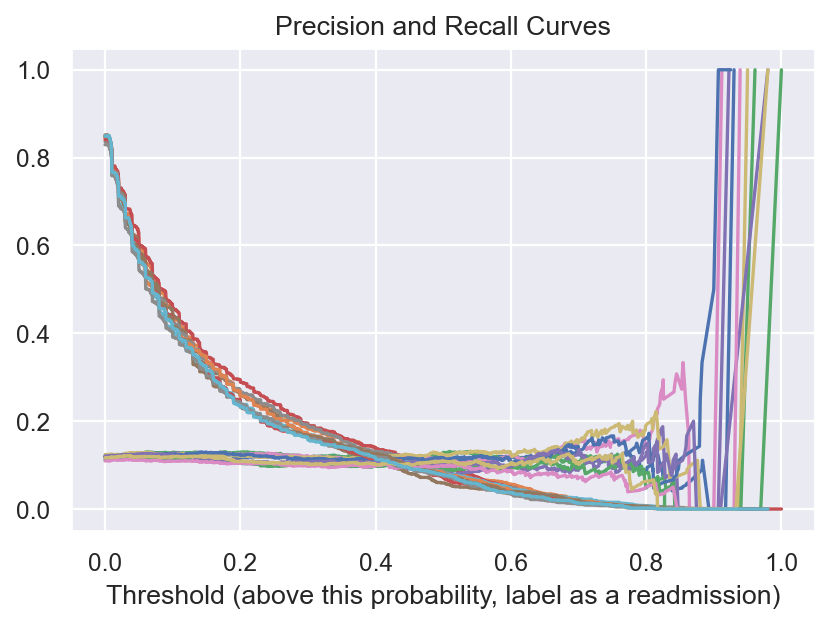

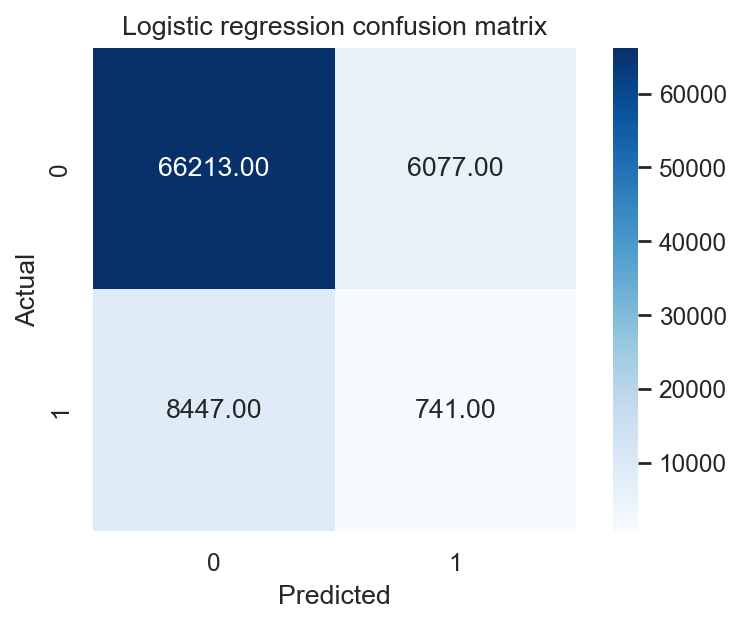

In [173]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.712 +- 0.002
F1 validation mean 10-fold cv: 0.102 +- 0.012
ROC-AUC mean 10-fold cv: 0.515 +- 0.008


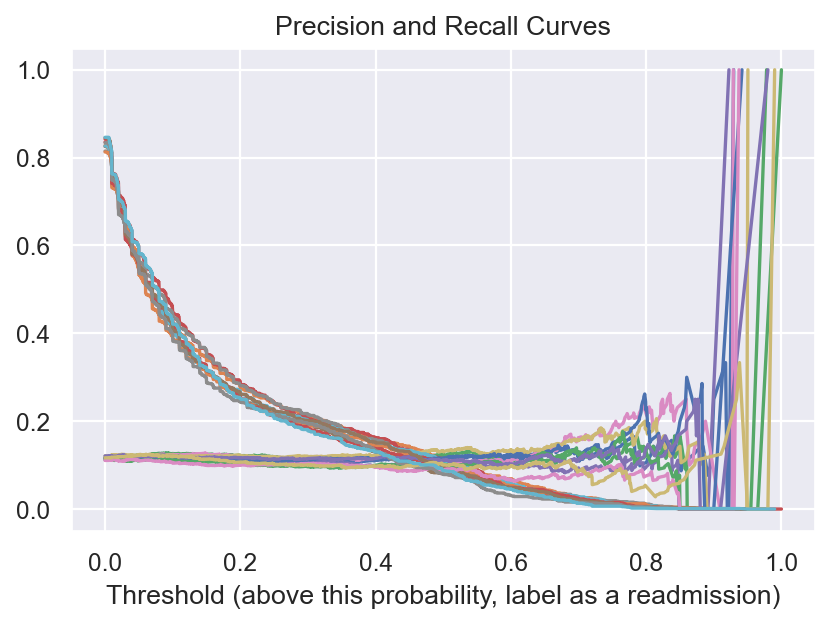

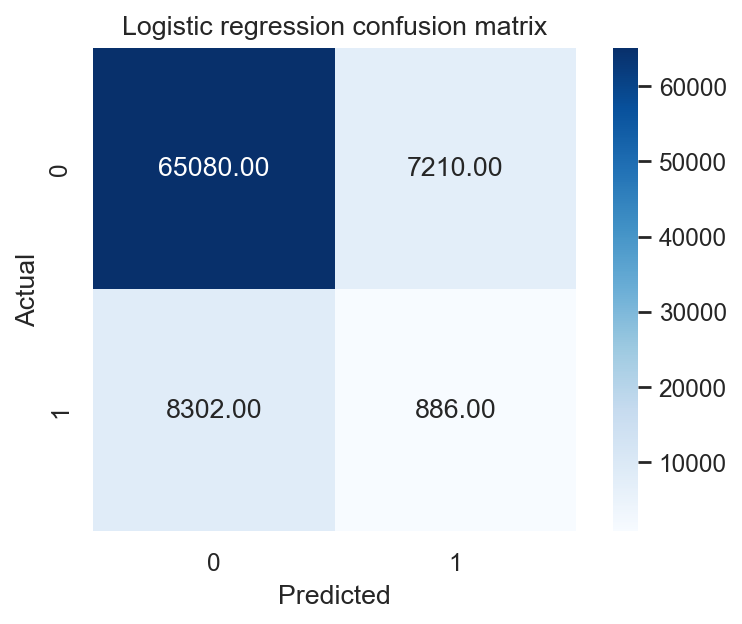

In [174]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.641 +- 0.002
F1 validation mean 10-fold cv: 0.121 +- 0.013
ROC-AUC mean 10-fold cv: 0.513 +- 0.008


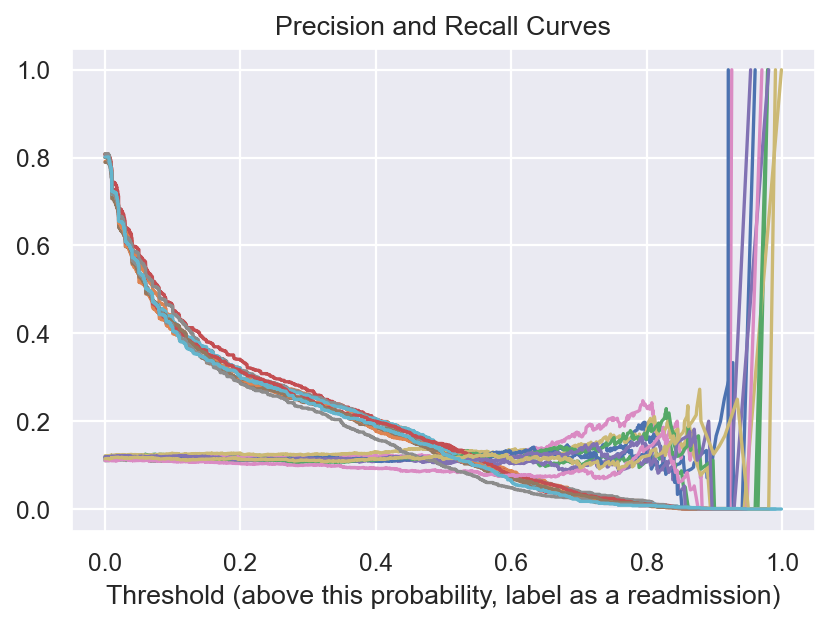

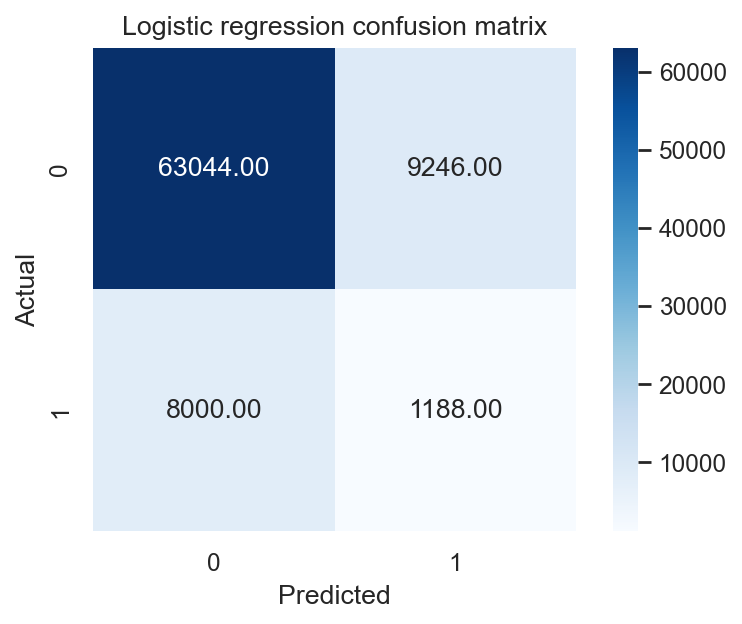

In [175]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.301 +- 0.001
F1 validation mean 10-fold cv: 0.181 +- 0.006
ROC-AUC mean 10-fold cv: 0.518 +- 0.012


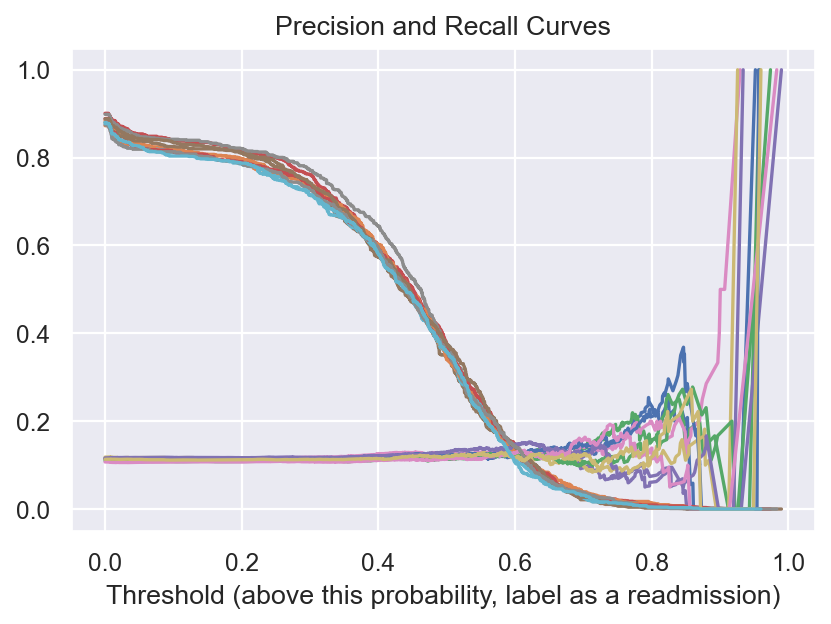

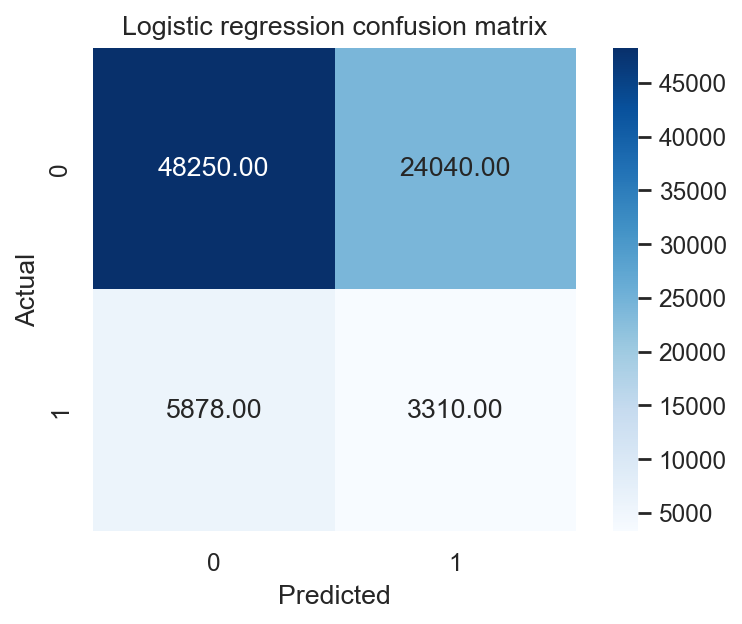

In [176]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.301 +- 0.001
F1 validation mean 10-fold cv: 0.181 +- 0.006
ROC-AUC mean 10-fold cv: 0.518 +- 0.012


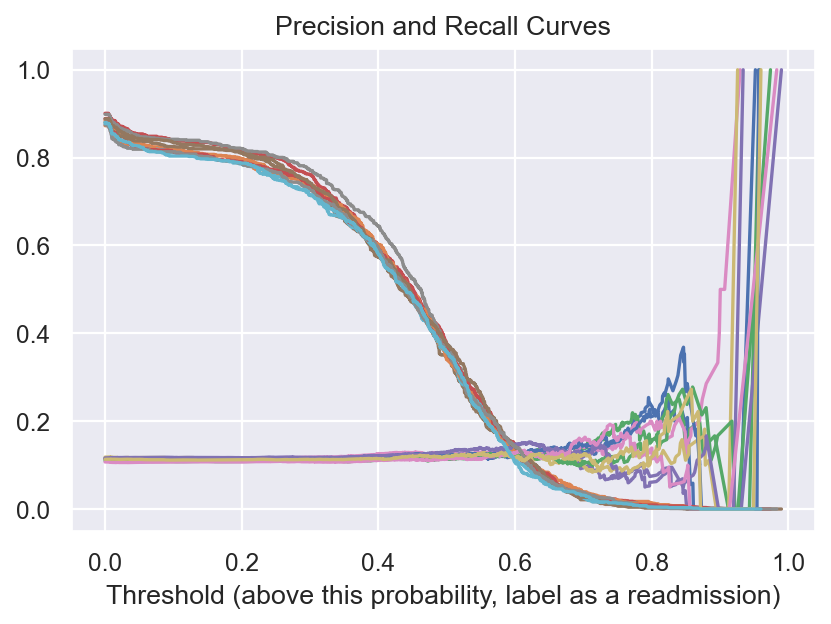

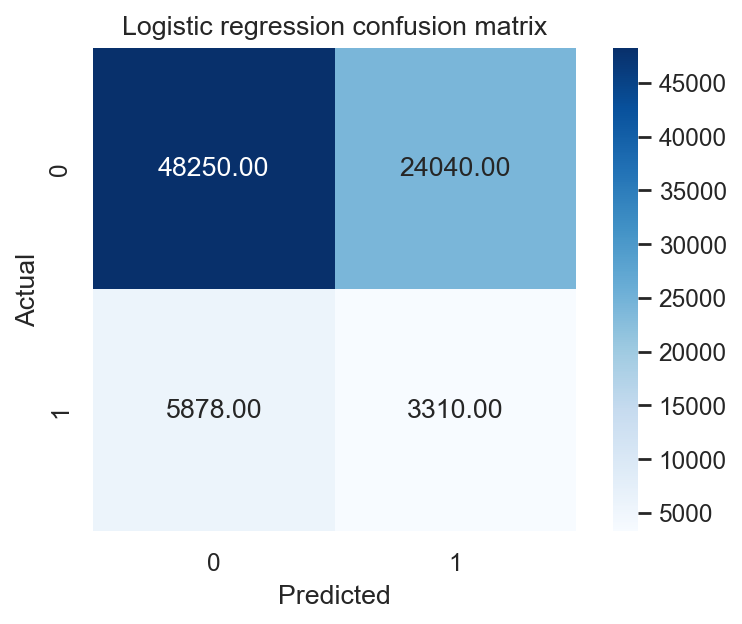

In [177]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.237 +- 0.001
F1 validation mean 10-fold cv: 0.191 +- 0.007
ROC-AUC mean 10-fold cv: 0.519 +- 0.011


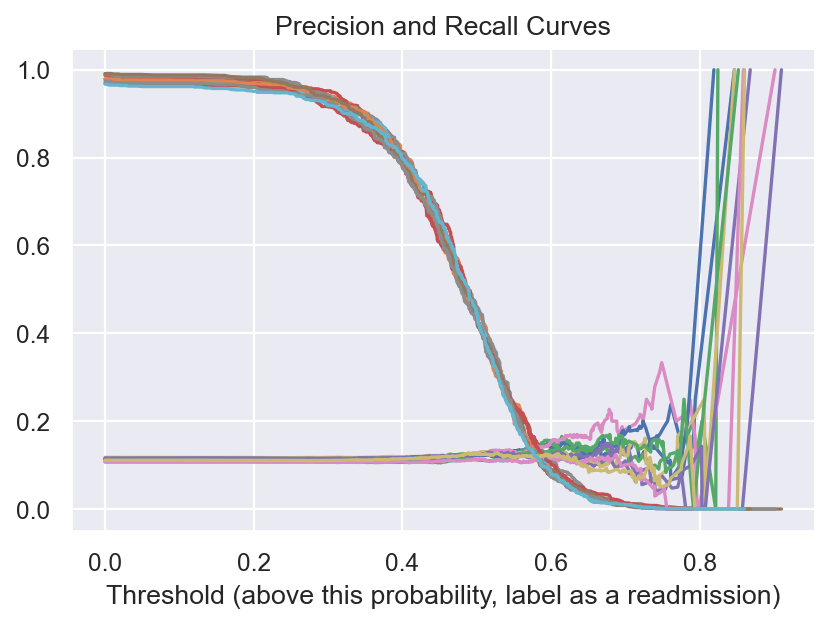

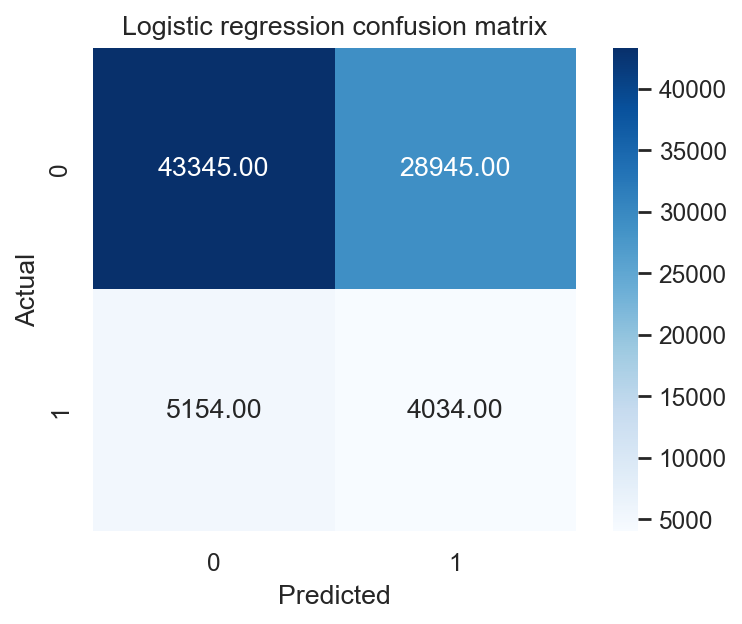

In [178]:
features_all_numerical = ['time_in_hospital','num_lab_procedures']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.209 +- 0.001
F1 validation mean 10-fold cv: 0.209 +- 0.006
ROC-AUC mean 10-fold cv: 0.549 +- 0.007


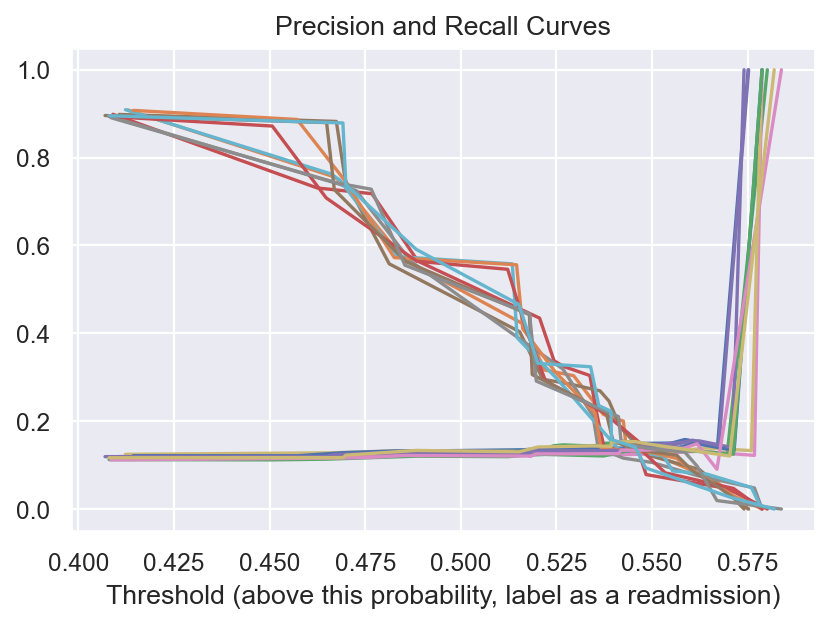

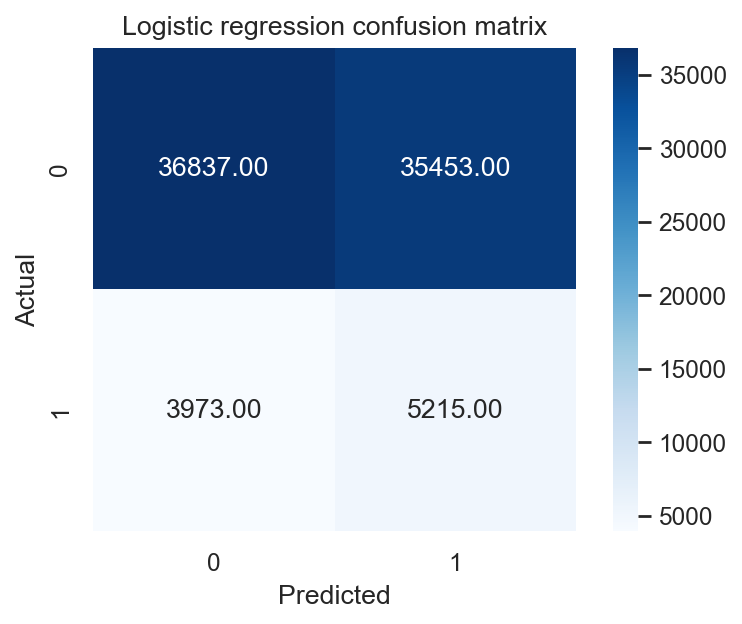

In [179]:
features_all_numerical = ['time_in_hospital']
random_forests_weightsBalanced(features_all_numerical)

F1 training mean 10-fold cv: 0.217 +- 0.001
F1 validation mean 10-fold cv: 0.213 +- 0.006
ROC-AUC mean 10-fold cv: 0.556 +- 0.008


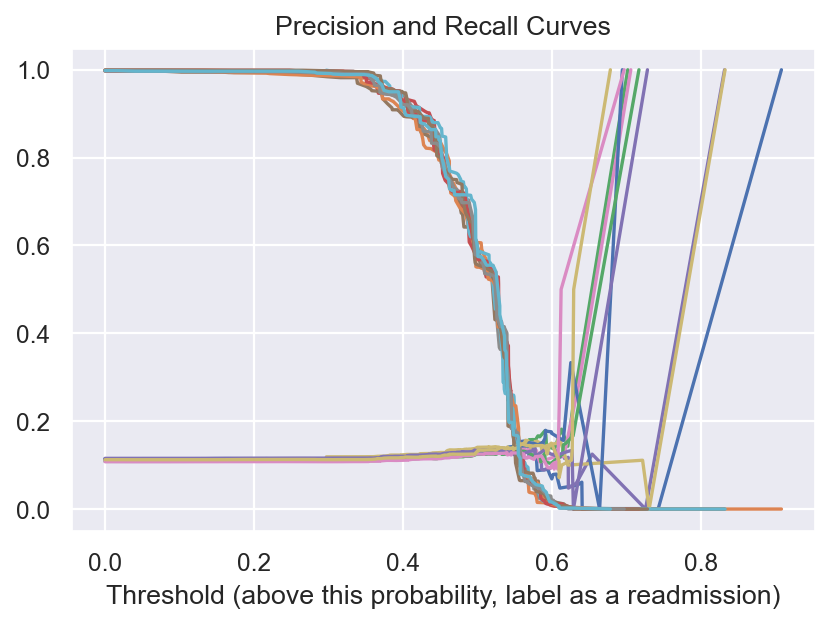

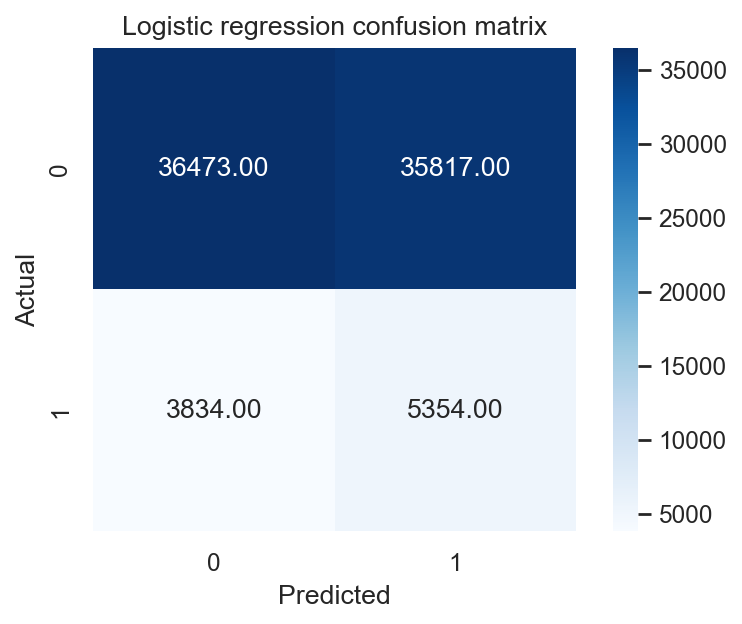

In [180]:
features_all_numerical = ['time_in_hospital','number_diagnoses']
random_forests_weightsBalanced(features_all_numerical)


F1 training mean 10-fold cv: 0.218 +- 0.001
F1 validation mean 10-fold cv: 0.215 +- 0.008
ROC-AUC mean 10-fold cv: 0.568 +- 0.010


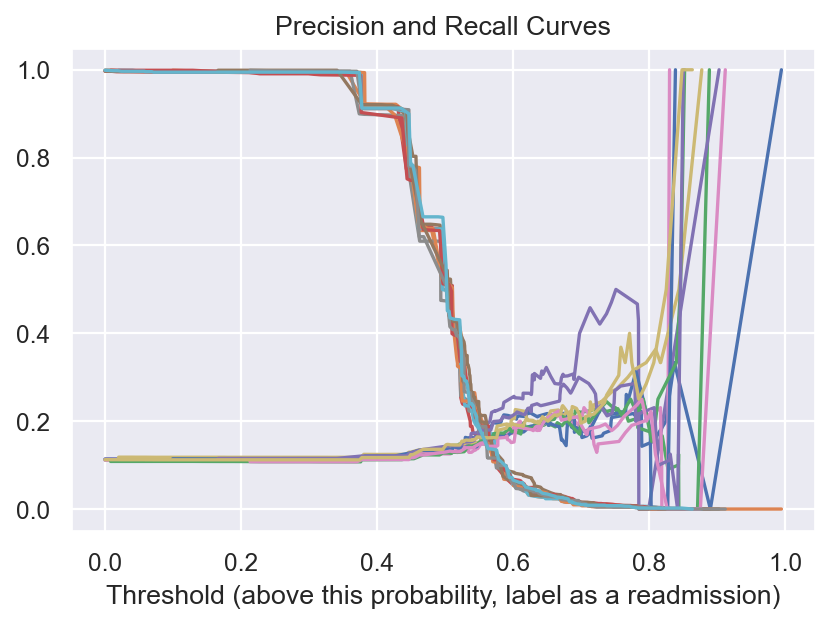

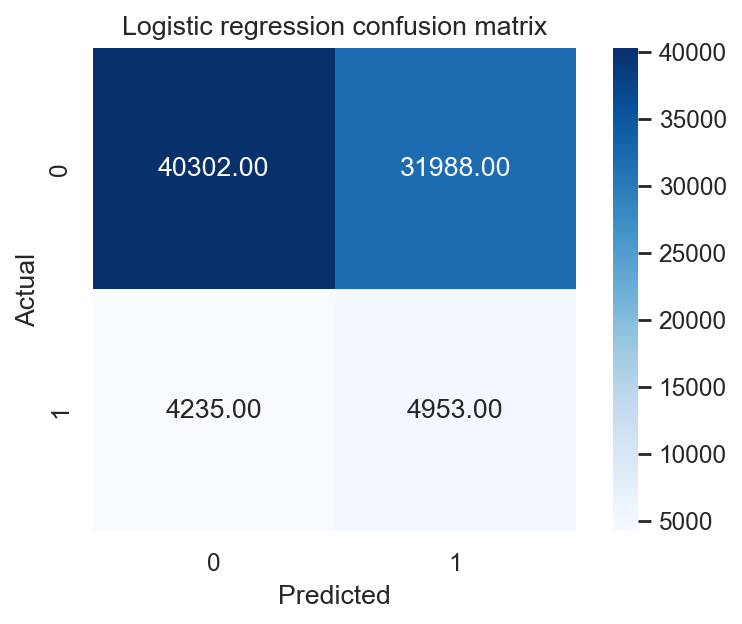

In [246]:
features_all_numerical = ['time_in_hospital','number_emergency'] # BEST SO FAR.
random_forests_weightsBalanced(features_all_numerical)



F1 training mean 10-fold cv: 0.228 +- 0.001
F1 validation mean 10-fold cv: 0.215 +- 0.007
ROC-AUC mean 10-fold cv: 0.565 +- 0.010


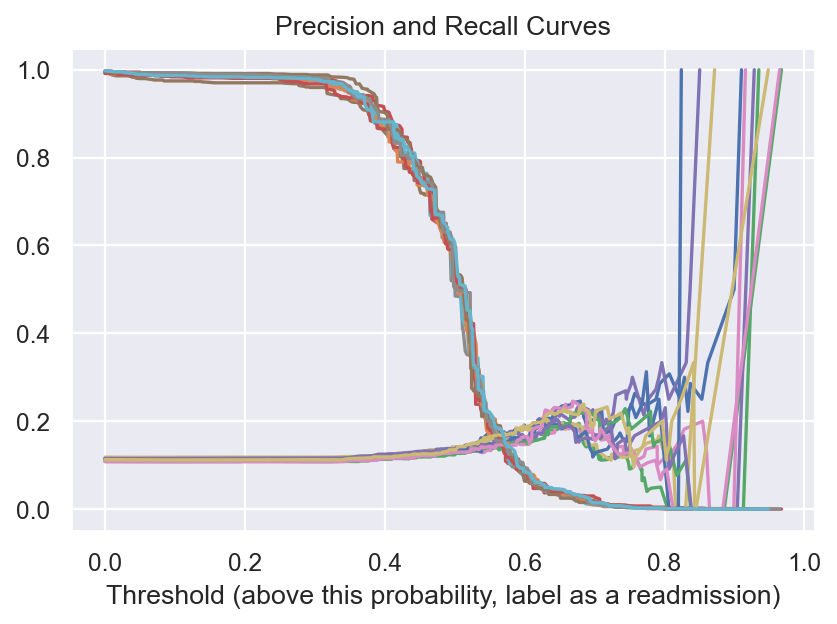

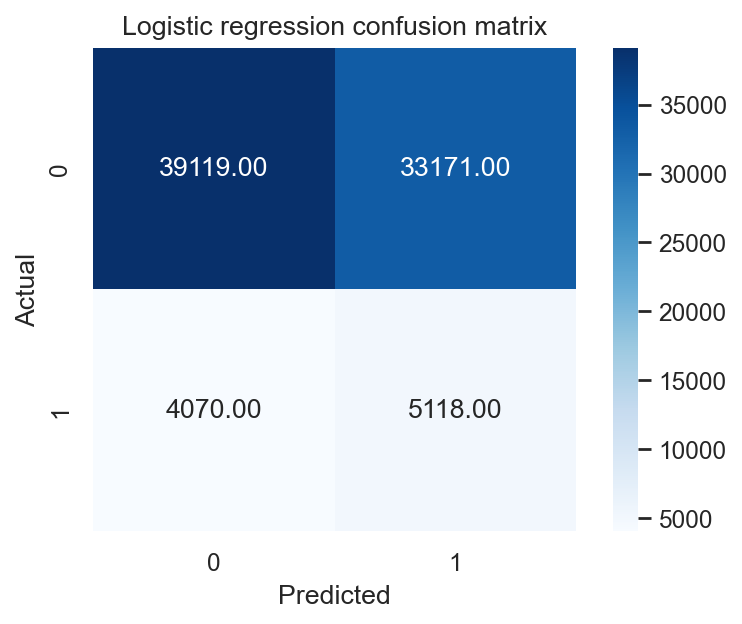

In [247]:
features_all_numerical = ['time_in_hospital','number_diagnoses','number_emergency']
random_forests_weightsBalanced(features_all_numerical)



F1 training mean 10-fold cv: 0.212 +- 0.001
F1 validation mean 10-fold cv: 0.210 +- 0.007
ROC-AUC mean 10-fold cv: 0.553 +- 0.008


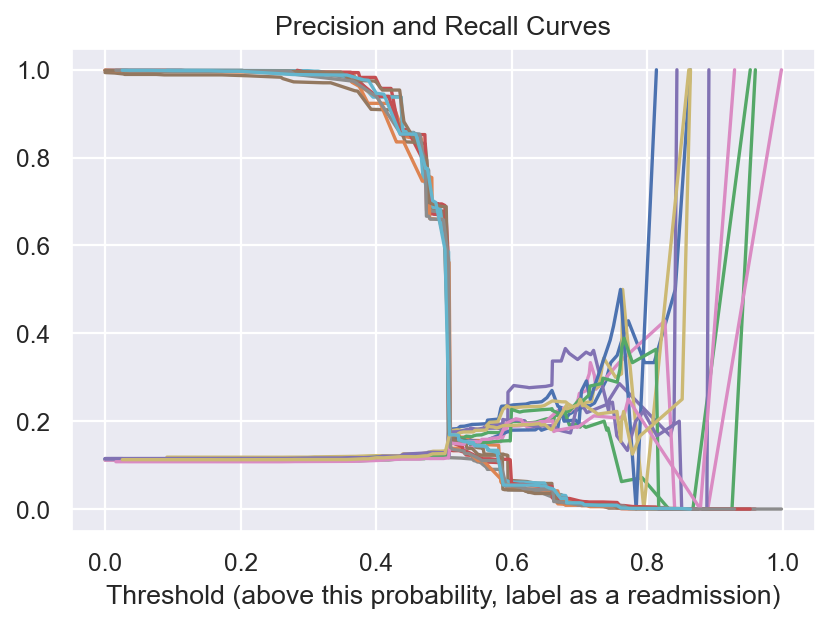

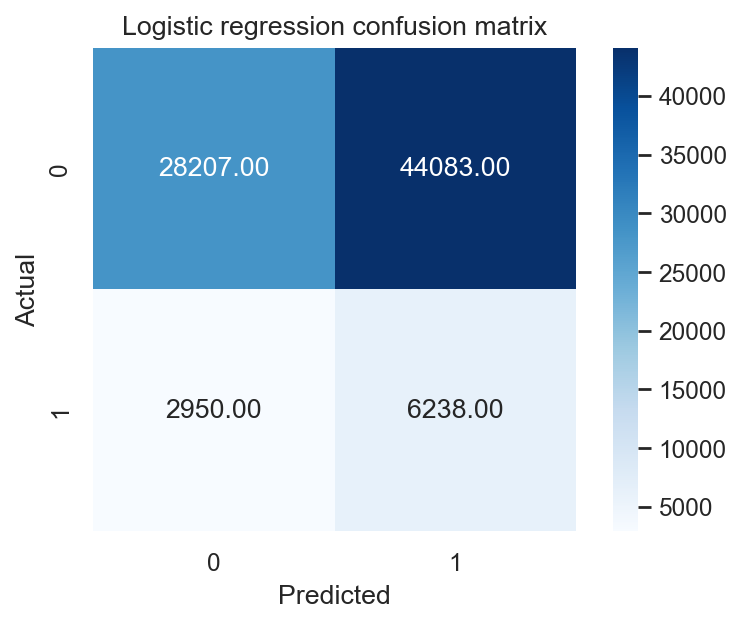

In [250]:
features_all_numerical = ['number_diagnoses','number_emergency']
random_forests_weightsBalanced(features_all_numerical)

# BEST

F1 training mean 10-fold cv: 0.249 +- 0.001
F1 validation mean 10-fold cv: 0.246 +- 0.010
ROC-AUC mean 10-fold cv: 0.602 +- 0.011


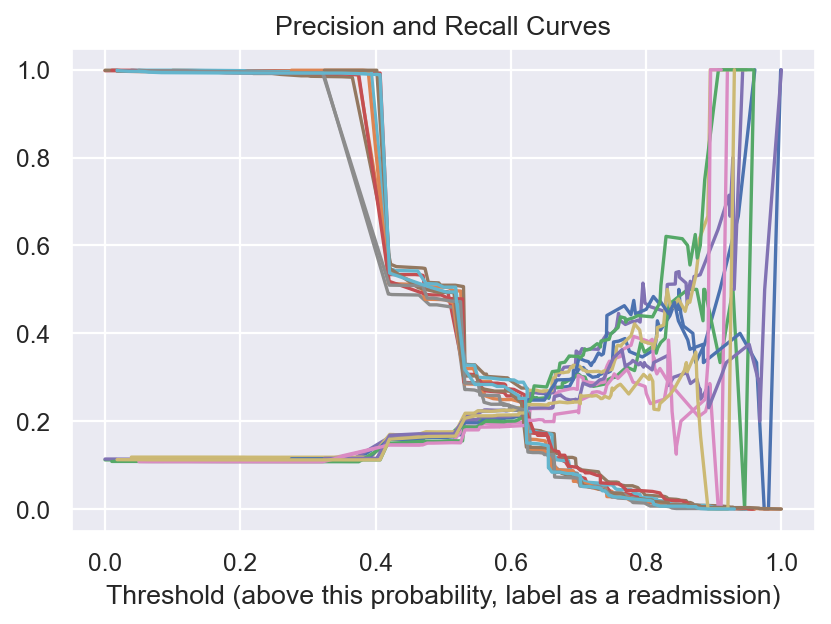

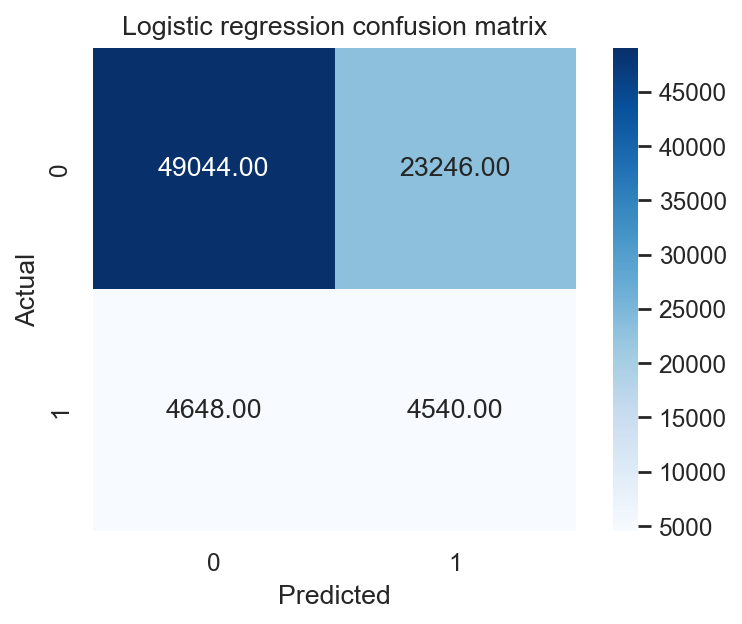

In [560]:
features_all_numerical = ['number_inpatient','number_emergency'] # BEST !!!!!!
random_forests_weightsBalanced(features_all_numerical,training_validation_set)

F1 training mean 10-fold cv: 0.249 +- 0.002
F1 validation mean 10-fold cv: 0.242 +- 0.010
ROC-AUC mean 10-fold cv: 0.619 +- 0.009


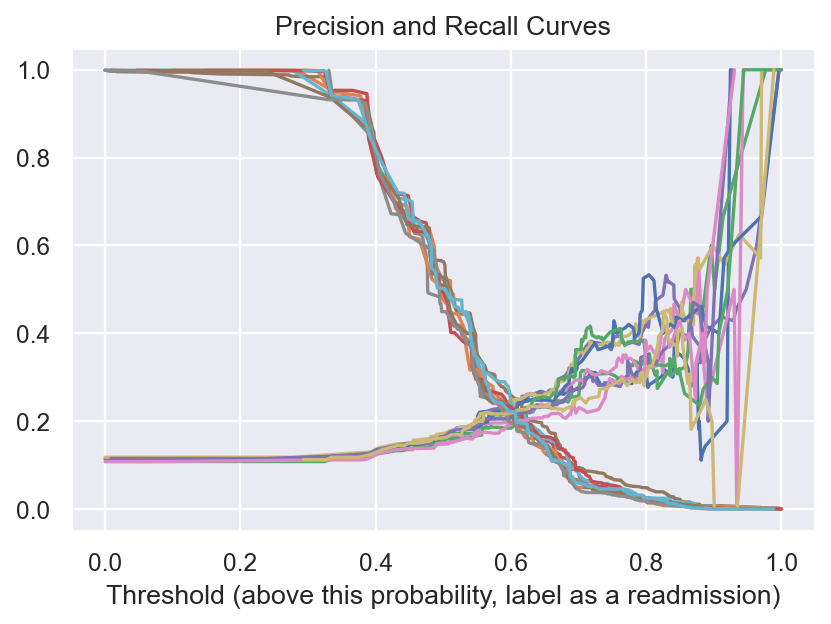

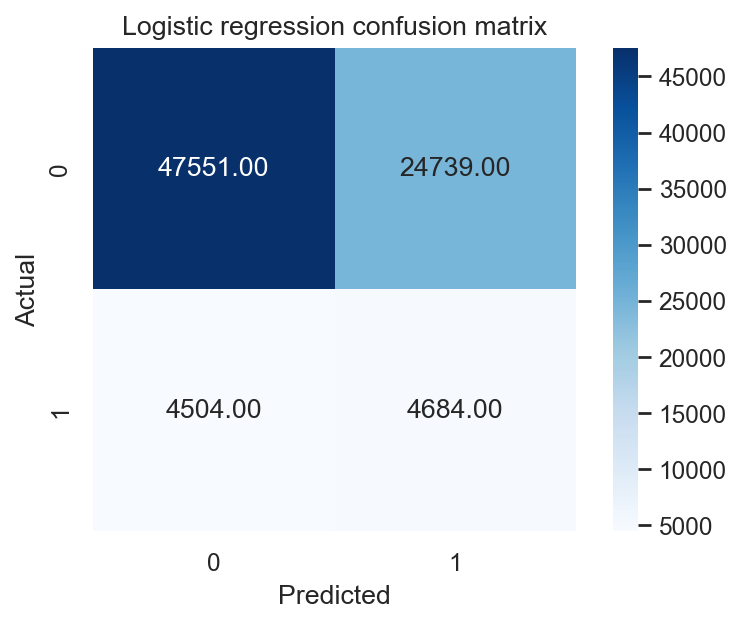

In [562]:
features_all_numerical = ['number_inpatient','time_in_hospital']
random_forests_weightsBalanced(features_all_numerical,training_validation_set)

Ok, so now, let's change the threshold to an optimal one (probably around ~ 0.2?)

In [582]:
def find_threshold_RF_weightsBalanced(features_all_numerical):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])
    
    thresh_ps = np.linspace(.10,0.7,1000) # Thresholds
       

    # cv_F1_training = []
    # cv_ROC_AUC = []
    # cv_F1_validation = []

    ct = 1
    max_f1_scores_cv = []
    max_thresh_p_cv = []
    f1_score_train_bestThresh_cv = []

    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] # OK WE GOT HERE

        forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        forest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
        
        model_val_probs = forest_balanced.predict_proba(X_val_fold)[:,1] # positive class probs, same basic logistic model we fit in section 2  OK!
        
        f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
        for p in thresh_ps:
            model_val_labels = model_val_probs >= p
            f1_scores.append(f1_score(y_val_fold, model_val_labels))  # HERE  
            prec_scores.append(precision_score(y_val_fold, model_val_labels))
            rec_scores.append(recall_score(y_val_fold, model_val_labels))
            acc_scores.append(accuracy_score(y_val_fold, model_val_labels))
            
    
        
        best_f1_score = np.max(f1_scores) 
        max_f1_scores_cv.append(np.max(f1_scores))
        
        best_thresh_p = thresh_ps[np.argmax(f1_scores)]  
        max_thresh_p_cv.append(thresh_ps[np.argmax(f1_scores)])
                
        print('Random Forests Model best F1 score %.3f at prob decision threshold >= %.3f' 
        % (best_f1_score, best_thresh_p))
        
    return max_f1_scores_cv,max_thresh_p_cv
        




In [ ]:
# Find the best score for random forests with all numerical variables.  

In [203]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)


Random Forests Model best F1 score 0.227 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.220 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.227 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.220 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.230 at prob decision threshold >= 0.106
Random Forests Model best F1 score 0.230 at prob decision threshold >= 0.110
Random Forests Model best F1 score 0.209 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.218 at prob decision threshold >= 0.100
Random Forests Model best F1 score 0.207 at prob decision threshold >= 0.120
Random Forests Model best F1 score 0.229 at prob decision threshold >= 0.135


AttributeError: 'list' object has no attribute 'mean'

In [206]:
print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

average_max_F1_score = 0.221789222692831
average_max_threshold = 0.1070870870870871


In [208]:
features_all_numerical = ['time_in_hospital']

max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)

print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

Random Forests Model best F1 score 0.215 at prob decision threshold >= 0.469
Random Forests Model best F1 score 0.207 at prob decision threshold >= 0.409
Random Forests Model best F1 score 0.216 at prob decision threshold >= 0.470
Random Forests Model best F1 score 0.209 at prob decision threshold >= 0.473
Random Forests Model best F1 score 0.220 at prob decision threshold >= 0.468
Random Forests Model best F1 score 0.219 at prob decision threshold >= 0.470
Random Forests Model best F1 score 0.200 at prob decision threshold >= 0.408
Random Forests Model best F1 score 0.212 at prob decision threshold >= 0.467
Random Forests Model best F1 score 0.202 at prob decision threshold >= 0.477
Random Forests Model best F1 score 0.218 at prob decision threshold >= 0.488
average_max_F1_score = 0.21168257116354577
average_max_threshold = 0.45995995995996


In [248]:
features_all_numerical = ['time_in_hospital','number_emergency']
max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)

print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

Random Forests Model best F1 score 0.219 at prob decision threshold >= 0.477
Random Forests Model best F1 score 0.219 at prob decision threshold >= 0.500
Random Forests Model best F1 score 0.222 at prob decision threshold >= 0.457
Random Forests Model best F1 score 0.209 at prob decision threshold >= 0.494
Random Forests Model best F1 score 0.223 at prob decision threshold >= 0.450
Random Forests Model best F1 score 0.221 at prob decision threshold >= 0.470
Random Forests Model best F1 score 0.207 at prob decision threshold >= 0.468
Random Forests Model best F1 score 0.226 at prob decision threshold >= 0.499
Random Forests Model best F1 score 0.205 at prob decision threshold >= 0.469
Random Forests Model best F1 score 0.226 at prob decision threshold >= 0.490
average_max_F1_score = 0.21768631425477283
average_max_threshold = 0.4773773773773774


In [251]:
features_all_numerical = ['time_in_hospital','number_diagnoses','number_emergency']
max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)

print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

Random Forests Model best F1 score 0.221 at prob decision threshold >= 0.500
Random Forests Model best F1 score 0.222 at prob decision threshold >= 0.450
Random Forests Model best F1 score 0.215 at prob decision threshold >= 0.494
Random Forests Model best F1 score 0.219 at prob decision threshold >= 0.493
Random Forests Model best F1 score 0.227 at prob decision threshold >= 0.461
Random Forests Model best F1 score 0.216 at prob decision threshold >= 0.475
Random Forests Model best F1 score 0.205 at prob decision threshold >= 0.456
Random Forests Model best F1 score 0.227 at prob decision threshold >= 0.474
Random Forests Model best F1 score 0.212 at prob decision threshold >= 0.496
Random Forests Model best F1 score 0.222 at prob decision threshold >= 0.493
average_max_F1_score = 0.21866839295556667
average_max_threshold = 0.47901901901901905


In [563]:
features_all_numerical = ['number_inpatient','number_emergency'] 
max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)

print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

Random Forests Model best F1 score 0.253 at prob decision threshold >= 0.482
Random Forests Model best F1 score 0.246 at prob decision threshold >= 0.472
Random Forests Model best F1 score 0.257 at prob decision threshold >= 0.478
Random Forests Model best F1 score 0.231 at prob decision threshold >= 0.490
Random Forests Model best F1 score 0.262 at prob decision threshold >= 0.475
Random Forests Model best F1 score 0.243 at prob decision threshold >= 0.476
Random Forests Model best F1 score 0.235 at prob decision threshold >= 0.475
Random Forests Model best F1 score 0.257 at prob decision threshold >= 0.421
Random Forests Model best F1 score 0.229 at prob decision threshold >= 0.486
Random Forests Model best F1 score 0.249 at prob decision threshold >= 0.479
average_max_F1_score = 0.24608259964216112
average_max_threshold = 0.4734134134134134


In [583]:
features_all_numerical = ['number_inpatient','number_emergency'] 
max_f1_scores_cv,max_thresh_p_cv = find_threshold_RF_weightsBalanced(features_all_numerical)

print(f'average_max_F1_score = {mean(max_f1_scores_cv)}')
print(f'average_max_threshold = {mean(max_thresh_p_cv)}')

Random Forests Model best F1 score 0.256 at prob decision threshold >= 0.545
Random Forests Model best F1 score 0.246 at prob decision threshold >= 0.507
Random Forests Model best F1 score 0.260 at prob decision threshold >= 0.564
Random Forests Model best F1 score 0.231 at prob decision threshold >= 0.516
Random Forests Model best F1 score 0.262 at prob decision threshold >= 0.546
Random Forests Model best F1 score 0.243 at prob decision threshold >= 0.515
Random Forests Model best F1 score 0.235 at prob decision threshold >= 0.475
Random Forests Model best F1 score 0.257 at prob decision threshold >= 0.421
Random Forests Model best F1 score 0.229 at prob decision threshold >= 0.513
Random Forests Model best F1 score 0.251 at prob decision threshold >= 0.532
average_max_F1_score = 0.247036940567388
average_max_threshold = 0.5135135135135135


And now, Run again random forests with the desired probability threshold:

In [244]:
def random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

        Randomforest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        Randomforest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
        
#         predicted_proba_train = Randomforest_balanced.predict_proba(X_train_fold)
#         predicted_validation_train = (predicted_proba_train[:,1] >= threshold).astype('int')
        
    
#       model_val_probs = forest_balanced.predict_proba(X_val_fold)[:,1] # positive class probs, same basic logistic model we fit in section 2  OK!
        
#         f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
#         for p in thresh_ps:
#             model_val_labels = model_val_probs >= p
#             f1_scores.append(f1_score(y_val_fold, model_val_labels))  # HERE  
#             prec_scores.append(precision_score(y_val_fold, model_val_labels))
#             rec_scores.append(recall_score(y_val_fold, model_val_labels))
#             acc_scores.append(accuracy_score(y_val_fold, model_val_labels))
            
            
            


        model_val_probs = Randomforest_balanced.predict_proba(X_val_fold)[:,1]
        model_val_labels = model_val_probs >= threshold
        
        model_train_probs = Randomforest_balanced.predict_proba(X_train_fold)[:,1]
        model_train_labels = model_train_probs >= threshold


        cv_F1_training.append(f1_score(y_train_fold, model_train_labels).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, model_val_labels).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, model_val_labels).round(3))

        # Recall-Precision curve
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold,model_val_labels)
        plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, model_val_labels)
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1
        
        del model_val_probs,model_val_labels,model_train_probs,model_train_labels


    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    plt.figure(dpi=80)
    # Print confusion matrix for logistic regression
    sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');



F1 training mean 10-fold cv: 0.727 +- 0.002
F1 validation mean 10-fold cv: 0.219 +- 0.009
ROC-AUC mean 10-fold cv: 0.555 +- 0.007


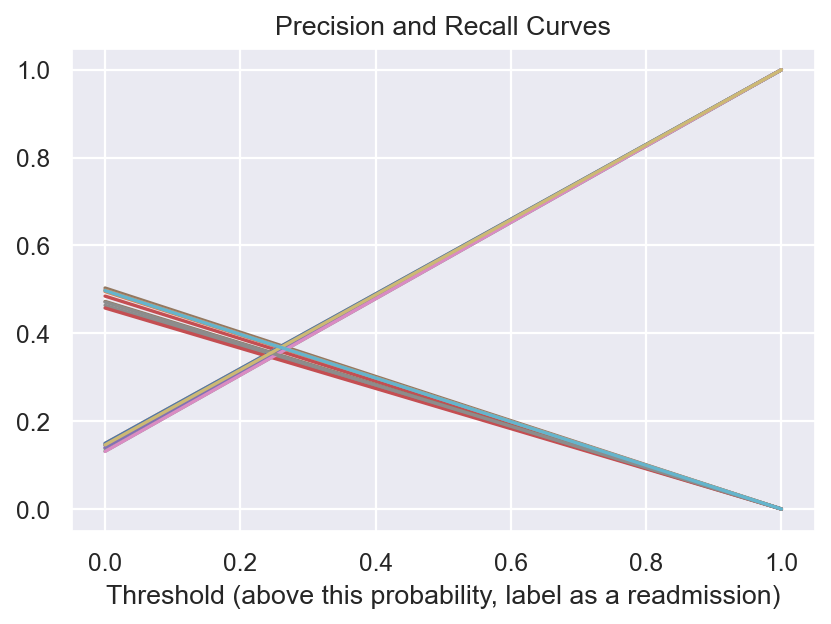

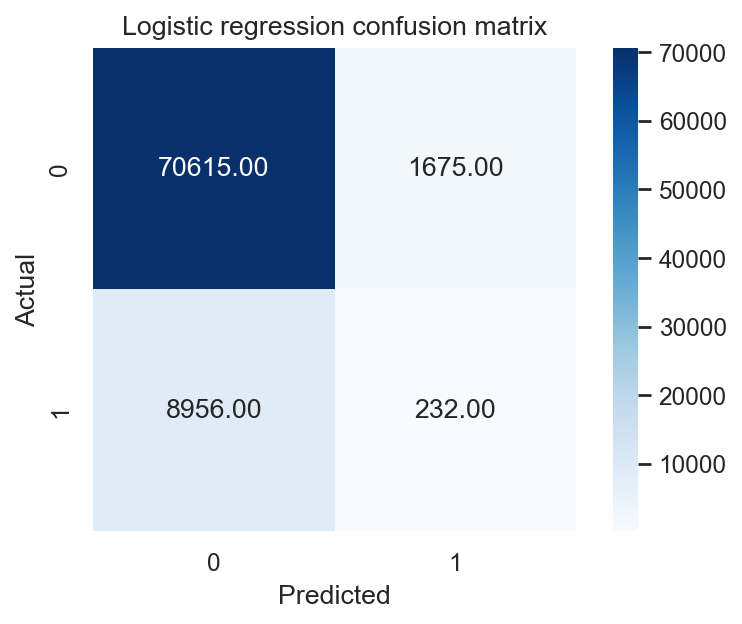

In [242]:
threshold = 0.107
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold)

F1 training mean 10-fold cv: 0.209 +- 0.001
F1 validation mean 10-fold cv: 0.208 +- 0.006
ROC-AUC mean 10-fold cv: 0.522 +- 0.005


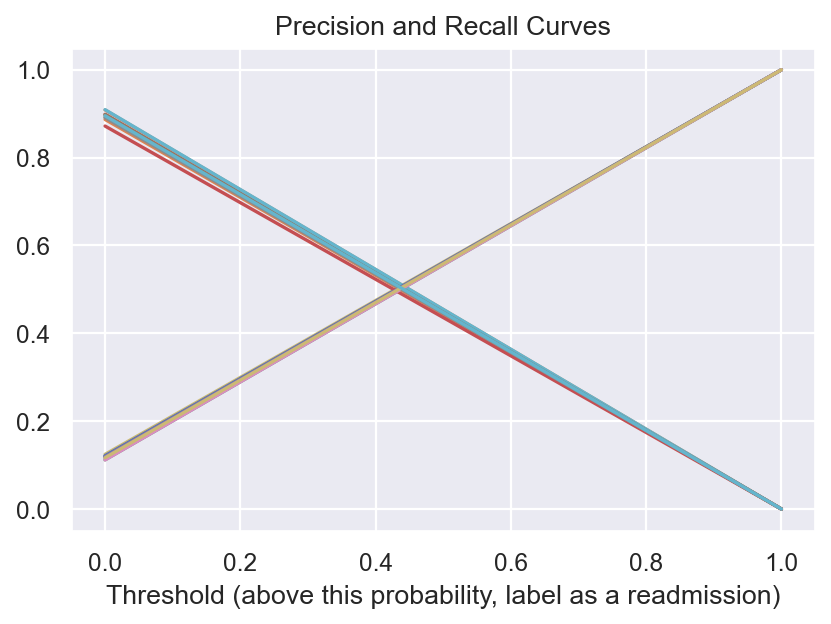

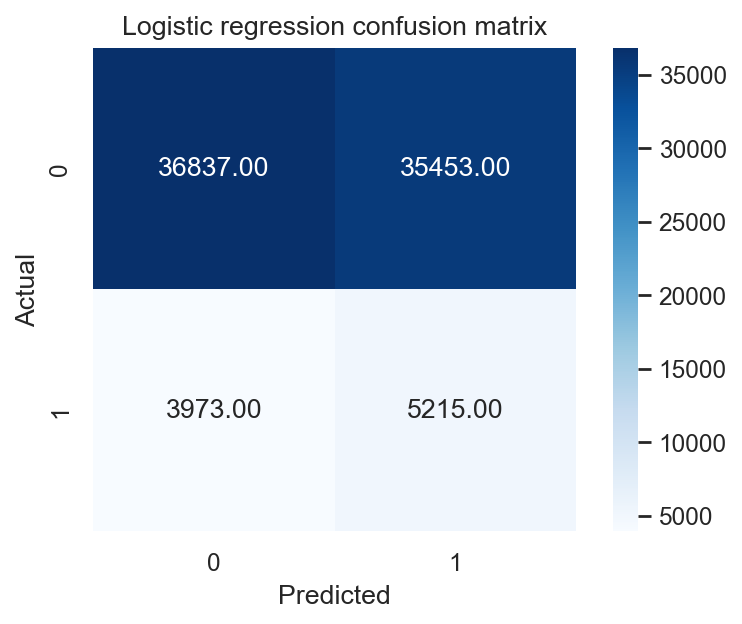

In [243]:
threshold = 0.459
features_all_numerical = ['time_in_hospital']
random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold)

F1 training mean 10-fold cv: 0.219 +- 0.001
F1 validation mean 10-fold cv: 0.217 +- 0.007
ROC-AUC mean 10-fold cv: 0.550 +- 0.007


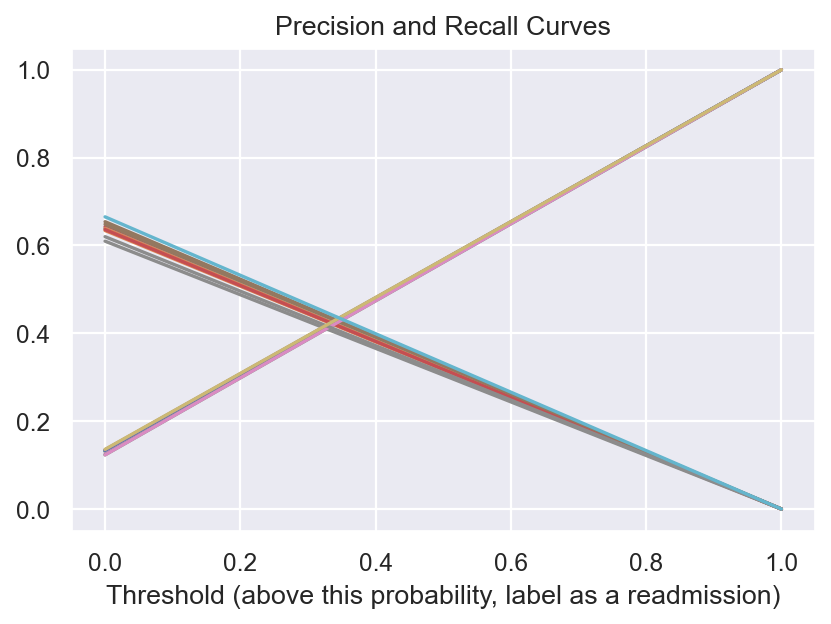

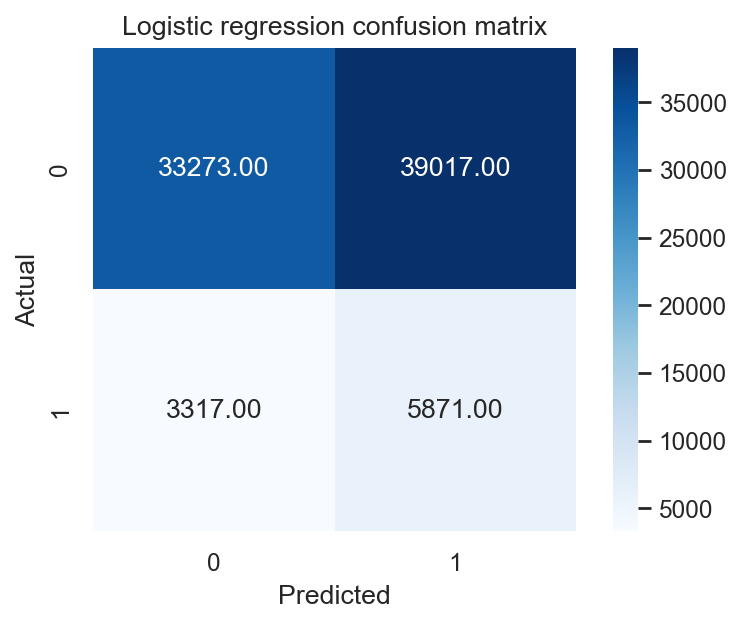

In [249]:
threshold = 0.477 # BEST! NOW WE NEED TO CHECK OVERSAMPLING - AND THEN, LET'S DO SOME FEATURE ENGINEERING.
features_all_numerical = ['time_in_hospital','number_emergency']
random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold)

F1 training mean 10-fold cv: 0.226 +- 0.001
F1 validation mean 10-fold cv: 0.215 +- 0.007
ROC-AUC mean 10-fold cv: 0.546 +- 0.008


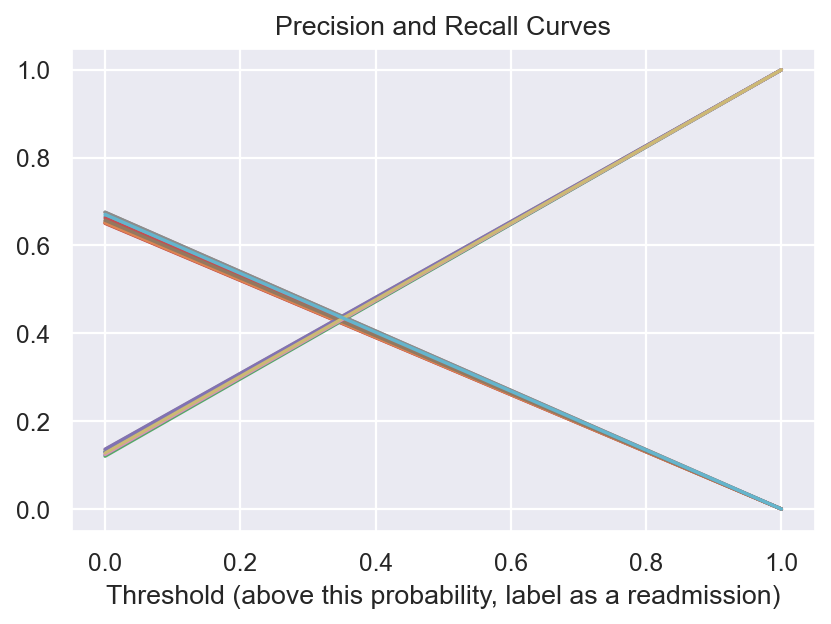

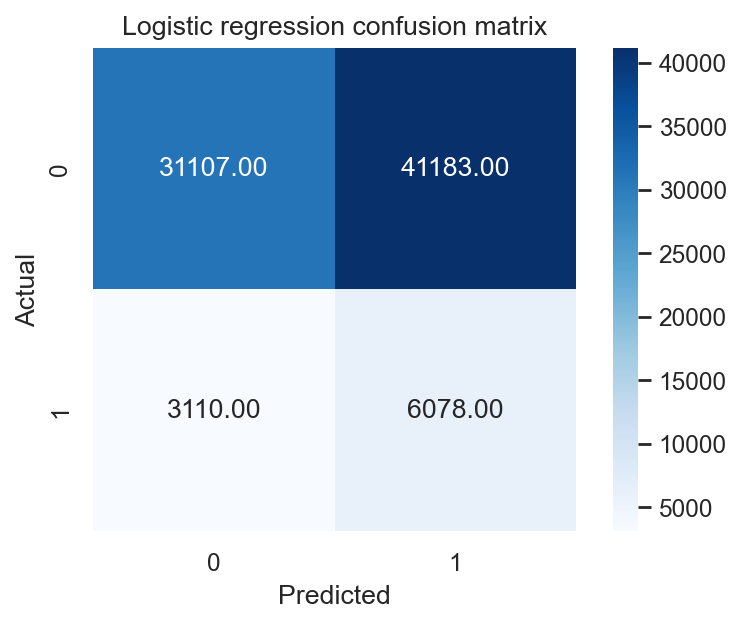

In [253]:
threshold = 0.479  
features_all_numerical = ['time_in_hospital','number_diagnoses','number_emergency']

random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold)

F1 training mean 10-fold cv: 0.247 +- 0.001
F1 validation mean 10-fold cv: 0.243 +- 0.012
ROC-AUC mean 10-fold cv: 0.585 +- 0.009


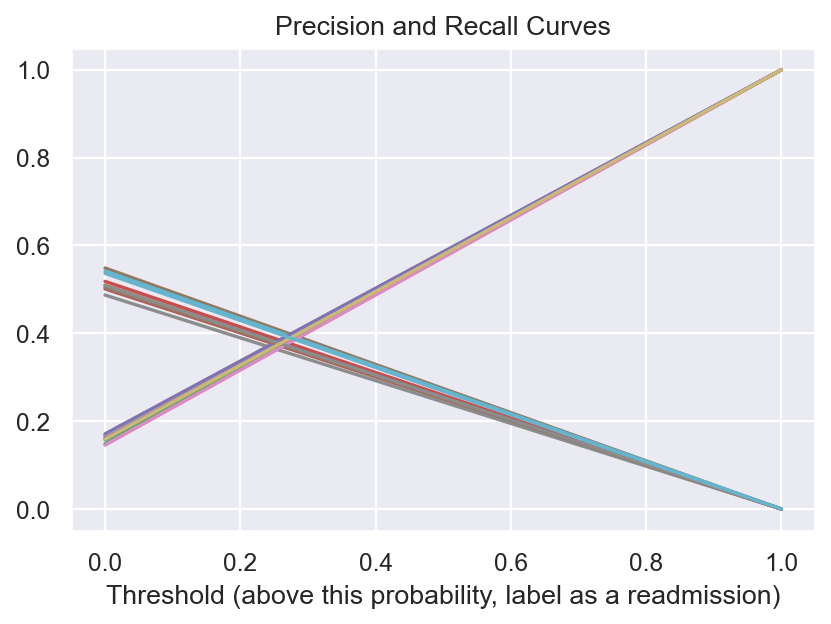

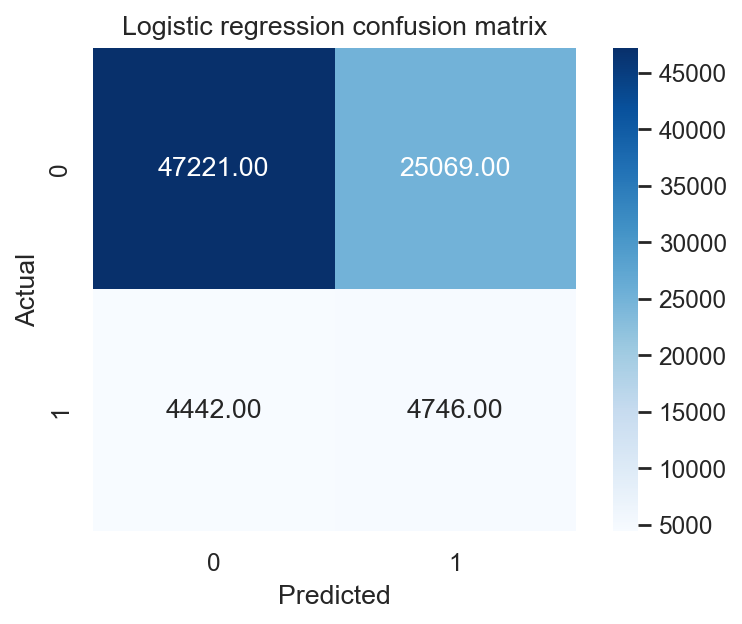

In [564]:
threshold = 0.473   # Weight does not work that well here!
features_all_numerical = ['number_inpatient','number_emergency'] 

random_forests_weightsBalanced_pthreshold(features_all_numerical,threshold)

## OVERSAMPLING NOW!

In [725]:
def random_forests_oversampling_weightsBalanced(features_all_numerical,training_validation_set):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])



    plt.figure(dpi=80)
    ct = 1

    for i in range(1,8):
    
        cv_F1_training = []
        cv_ROC_AUC = []
        cv_F1_validation = []

        for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
            X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
            X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

            # setup for the ratio argument of RandomOverSampler initialization
            n_pos = np.sum(y_train_fold == 1)
            n_neg = np.sum(y_train_fold == 0)
            # num = n_pos*(n_neg/n_pos)


            # ratio = {1 : round(n_pos*(n_neg/n_pos)), 0 : n_neg} # ratio = {1 : n_pos * 4, 0 : n_neg}
            ratio = {1 : n_pos * i, 0 : n_neg} # ratio = {1 : n_pos * 4, 0 : n_neg}

            # print(ratio,len(y_train_fold),n_pos,n_neg,n_neg/n_pos)

            # randomly oversample positive samples: create 4x as many 
            ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
            X_train_fold_rs, y_train_fold_rs = ROS.fit_resample(X_train_fold, y_train_fold)

            forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
            forest_balanced.fit(X_train_fold_rs, y_train_fold_rs.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

            cv_F1_training.append(f1_score(y_train_fold_rs, forest_balanced.predict(X_train_fold_rs)).round(3))
            cv_F1_validation.append(f1_score(y_val_fold, forest_balanced.predict(X_val_fold)).round(3))
            cv_ROC_AUC.append(roc_auc_score(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1]).round(3))

            # Recall-Precision curve
            # precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1])
            # plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
            # plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
            # # plt.legend(loc='lower left')
            # plt.xlabel('Threshold (above this probability, label as a readmission)');
            # plt.title('Precision and Recall Curves');

            # Confusion matrix
            confusion = confusion_matrix(y_val_fold, forest_balanced.predict(X_val_fold))
            if ct ==1:
                 confusion_final = confusion
            else:
                confusion_final +=confusion
            ct+=1

        
            
            
        print(i)       
        print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
        print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
        print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    # plt.figure(dpi=80)
    # # Print confusion matrix for logistic regression
    # sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title('Logistic regression confusion matrix');





In [727]:
# features_all = ['number_inpatient','number_emergency']  + list_dummy_variables
# random_forests_oversampling_weightsBalanced(features_all,training_validation_set_catUpdated)


In [578]:
features_all_numerical = ['number_inpatient','number_emergency'] # BEST SO FAR.
random_forests_oversampling_weightsBalanced(features_all_numerical)

1
F1 training mean 10-fold cv: 0.249 +- 0.001
F1 validation mean 10-fold cv: 0.246 +- 0.010
ROC-AUC mean 10-fold cv: 0.602 +- 0.011
2
F1 training mean 10-fold cv: 0.364 +- 0.002
F1 validation mean 10-fold cv: 0.246 +- 0.011
ROC-AUC mean 10-fold cv: 0.602 +- 0.011
3
F1 training mean 10-fold cv: 0.429 +- 0.002
F1 validation mean 10-fold cv: 0.246 +- 0.011
ROC-AUC mean 10-fold cv: 0.603 +- 0.011
4
F1 training mean 10-fold cv: 0.472 +- 0.002
F1 validation mean 10-fold cv: 0.246 +- 0.011
ROC-AUC mean 10-fold cv: 0.603 +- 0.012
5
F1 training mean 10-fold cv: 0.502 +- 0.003
F1 validation mean 10-fold cv: 0.246 +- 0.011
ROC-AUC mean 10-fold cv: 0.603 +- 0.011
6
F1 training mean 10-fold cv: 0.523 +- 0.003
F1 validation mean 10-fold cv: 0.246 +- 0.011
ROC-AUC mean 10-fold cv: 0.603 +- 0.011
7
F1 training mean 10-fold cv: 0.540 +- 0.003
F1 validation mean 10-fold cv: 0.247 +- 0.011
ROC-AUC mean 10-fold cv: 0.603 +- 0.011


<Figure size 480x320 with 0 Axes>

{1: 33036, 0: 65053} 73312 8259 65053 7.876619445453445
{1: 33080, 0: 65014} 73284 8270 65014 7.8614268440145105
{1: 32976, 0: 64942} 73186 8244 64942 7.877486656962639
{1: 33164, 0: 65126} 73417 8291 65126 7.855023519478953
{1: 32832, 0: 64973} 73181 8208 64973 7.915813840155946
{1: 33076, 0: 65181} 73450 8269 65181 7.882573467166526
{1: 33256, 0: 65106} 73420 8314 65106 7.830887659369738
{1: 33028, 0: 65142} 73399 8257 65142 7.889306043357151
{1: 33236, 0: 65018} 73327 8309 65018 7.8250090263569625
{1: 33084, 0: 65055} 73326 8271 65055 7.865433442147261
F1 training mean 10-fold cv: 0.453 +- 0.012
F1 validation mean 10-fold cv: 0.216 +- 0.009
ROC-AUC mean 10-fold cv: 0.568 +- 0.011


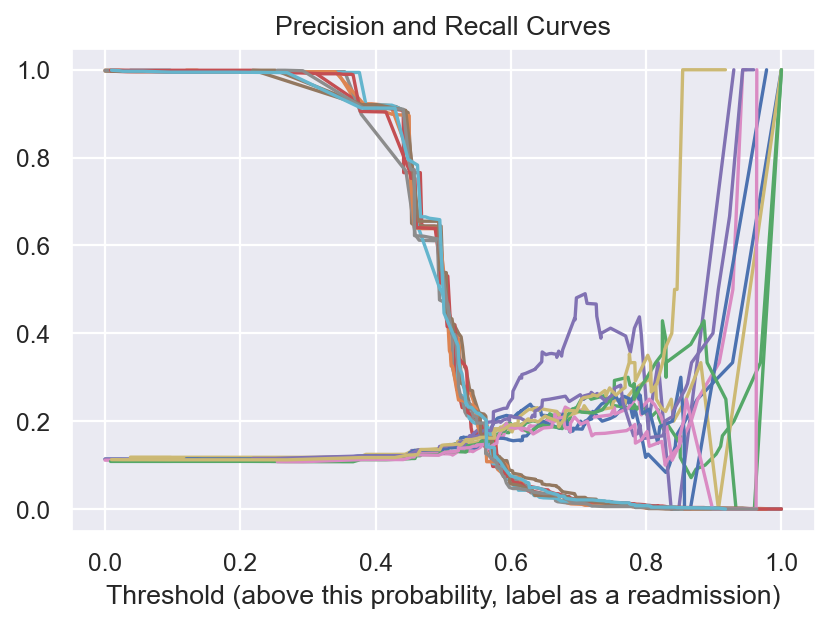

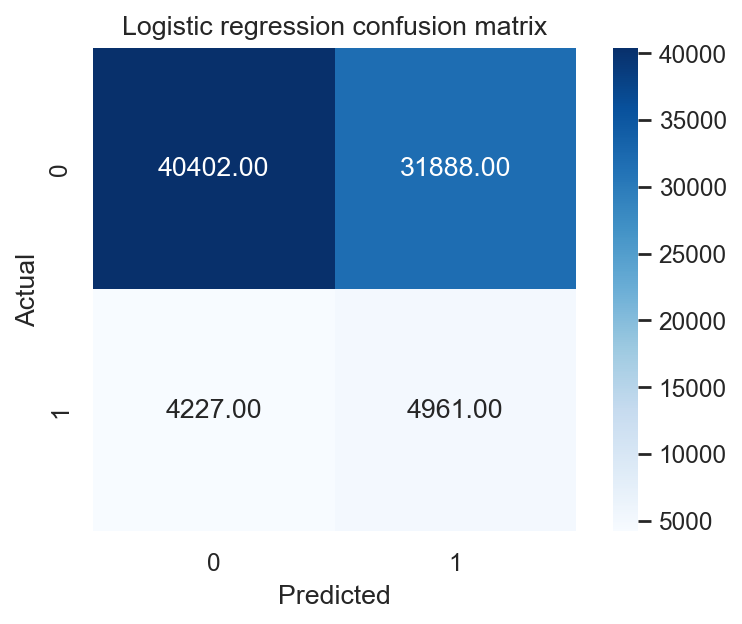

In [296]:
features_all_numerical = ['time_in_hospital','number_emergency'] # BEST SO FAR.
random_forests_oversampling_weightsBalanced(features_all_numerical)

Let's try logistic regression again!
              

In [306]:
def LR_oversampling_weightsBalanced(features_all_numerical):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
                
        # setup for the ratio argument of RandomOverSampler initialization
        n_pos = np.sum(y_train_fold == 1)
        n_neg = np.sum(y_train_fold == 0)
        # num = n_pos*(n_neg/n_pos)
              
        # ratio = {1 : round(n_pos*(n_neg/n_pos)), 0 : n_neg} # ratio = {1 : n_pos * 4, 0 : n_neg}
        
        ratio = {1 : n_pos * 4, 0 : n_neg} # ratio = {1 : n_pos * 4, 0 : n_neg}
        
        print(ratio,len(y_train_fold),n_pos,n_neg,n_neg/n_pos)

        # randomly oversample positive samples: create 4x as many 
        ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
        X_train_fold_rs, y_train_fold_rs = ROS.fit_resample(X_train_fold, y_train_fold)
        
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(X_train_fold_rs, y_train_fold_rs.ravel())
        
        # forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        # forest_balanced.fit(X_train_fold_rs, y_train_fold_rs.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        cv_F1_training.append(f1_score(y_train_fold_rs, lr.predict(X_train_fold_rs)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, lr.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, lr.predict_proba(X_val_fold)[:,1]).round(3))

        # Recall-Precision curve
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, lr.predict_proba(X_val_fold)[:,1])
        plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, lr.predict(X_val_fold))
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1


    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    plt.figure(dpi=80)
    # Print confusion matrix for logistic regression
    sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');





{1: 33036, 0: 65053} 73312 8259 65053 7.876619445453445
{1: 33080, 0: 65014} 73284 8270 65014 7.8614268440145105
{1: 32976, 0: 64942} 73186 8244 64942 7.877486656962639
{1: 33164, 0: 65126} 73417 8291 65126 7.855023519478953
{1: 32832, 0: 64973} 73181 8208 64973 7.915813840155946
{1: 33076, 0: 65181} 73450 8269 65181 7.882573467166526
{1: 33256, 0: 65106} 73420 8314 65106 7.830887659369738
{1: 33028, 0: 65142} 73399 8257 65142 7.889306043357151
{1: 33236, 0: 65018} 73327 8309 65018 7.8250090263569625
{1: 33084, 0: 65055} 73326 8271 65055 7.865433442147261
F1 training mean 10-fold cv: 0.417 +- 0.002
F1 validation mean 10-fold cv: 0.213 +- 0.008
ROC-AUC mean 10-fold cv: 0.571 +- 0.010


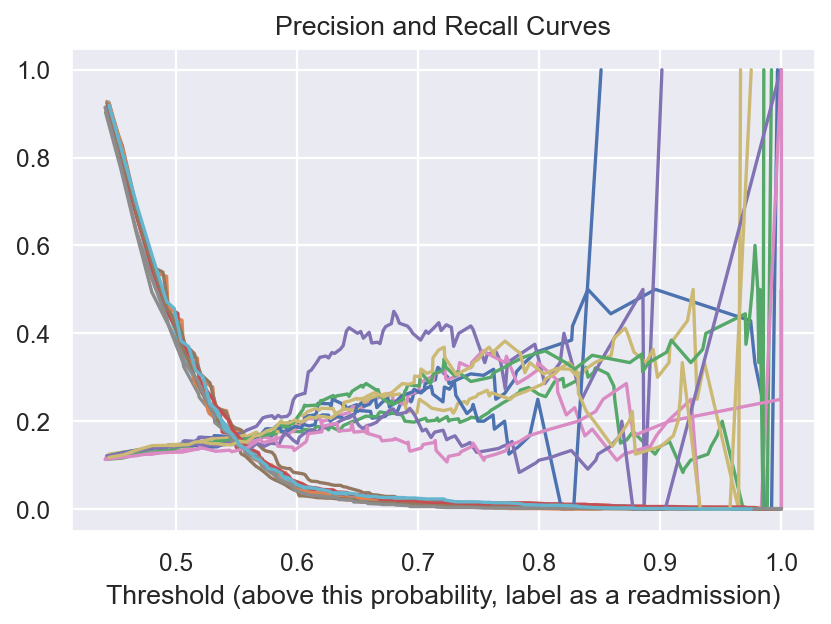

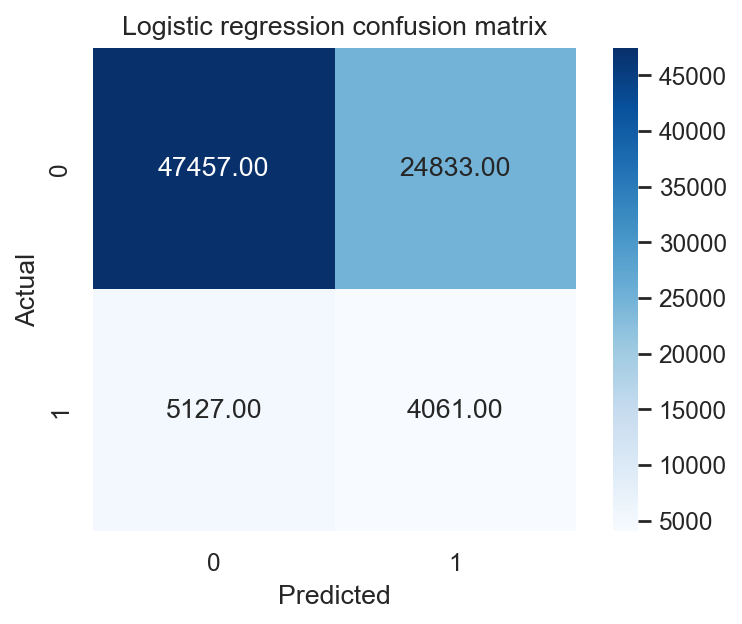

In [307]:
features_all_numerical = ['time_in_hospital','number_emergency'] # GOOD SO FAR AS WELL!
LR_oversampling_weightsBalanced(features_all_numerical)

In [300]:
def LR_weightsBalanced(features_all_numerical):

    X_train = np.array(training_validation_set[features_all_numerical])
    y_train = np.array(training_validation_set[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

        forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        forest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        cv_F1_training.append(f1_score(y_train_fold, forest_balanced.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, forest_balanced.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1]).round(3))

        # Recall-Precision curve
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1])
        plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, forest_balanced.predict(X_val_fold))
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1


    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    plt.figure(dpi=80)
    # Print confusion matrix for logistic regression
    sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');





F1 training mean 10-fold cv: 0.218 +- 0.001
F1 validation mean 10-fold cv: 0.215 +- 0.008
ROC-AUC mean 10-fold cv: 0.568 +- 0.010


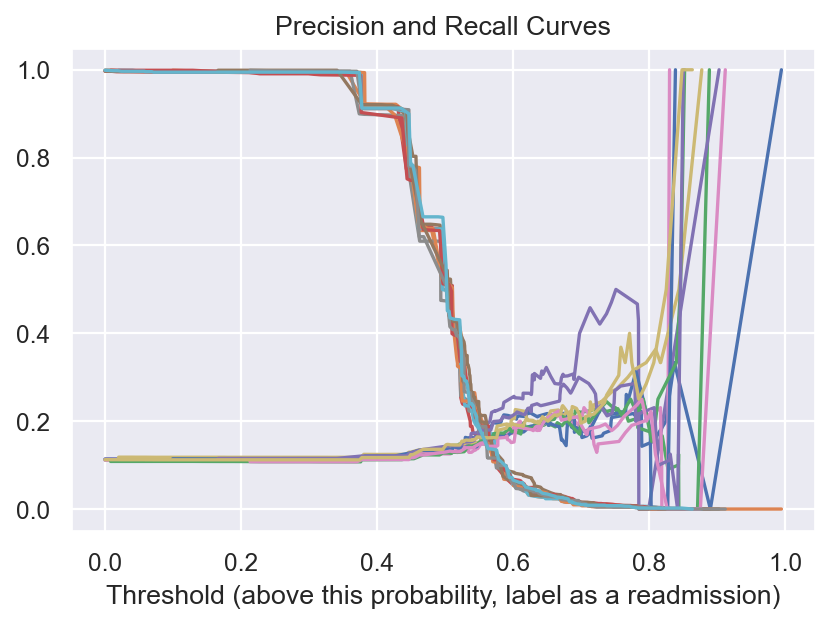

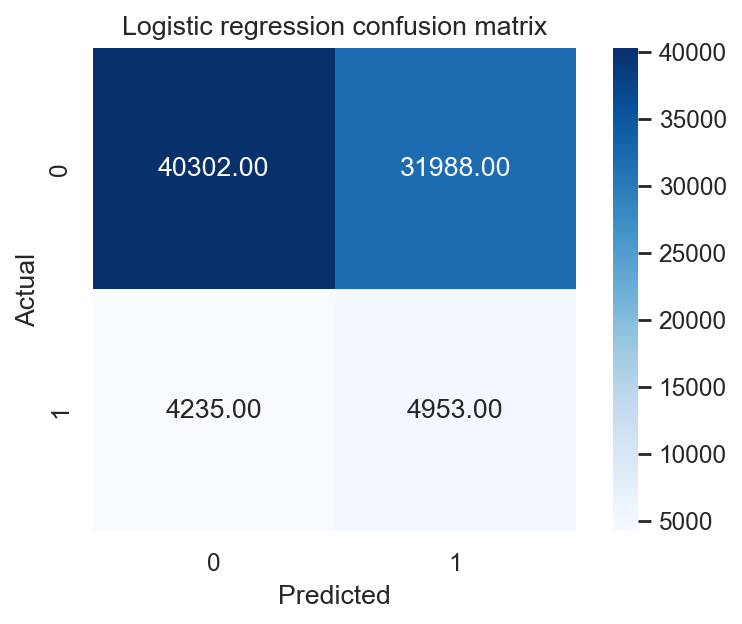

In [301]:
features_all_numerical = ['time_in_hospital','number_emergency'] # GOOD SO FAR AS WELL!
LR_weightsBalanced(features_all_numerical)

Both models, LR and RF, work similar. These are the features chosen = ['time_in_hospital','number_emergency']
We seem to have reached a plateau of ~0.21 for this problem, with this features. Now, let's add some categorical features.

In [329]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [465]:
def update_categorical_variable(column,diabetic_data2):
    diabetic_data2[column].fillna('null_value',inplace=True)
    data = pd.DataFrame(diabetic_data2.groupby([column])['encounter_id'].count()).reset_index().rename(columns = {'encounter_id': 'count'}.copy())
    data['count'] = (data['count']/data['count'].sum()*100)
    data.rename(columns={'count':'percentage'},inplace = True)
    data.set_index(column,inplace=True)
    
    for i in range(len(diabetic_data2)):
         if data.percentage[diabetic_data2[column].iloc[i]] < 5.0:
            diabetic_data2.at[i,column]= 'Other'
 
    return diabetic_data2[column]
    

In [496]:
list_cat_columns = []
for column in columns:
    if dtype(diabetic_data[column]) == 'object' and column !='readmitted' and column !='readmitted_binary_target':
        list_cat_columns.append(column)
        diabetic_data2[column] = update_categorical_variable(column,diabetic_data2)
        

In [497]:
list_cat_columns

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [498]:
diabetic_data_with_dummies = pd.get_dummies(diabetic_data2, columns=list_cat_columns, drop_first=True)

In [500]:
training_validation_set_catUpdated,test_set_catUpdated =  get_trainValidation80_test20_split(diabetic_data_with_dummies)



In [502]:
diabetic_data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 74 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   encounter_id                              101766 non-null  int64 
 1   patient_nbr                               101766 non-null  int64 
 2   admission_type_id                         101766 non-null  int64 
 3   discharge_disposition_id                  101766 non-null  int64 
 4   admission_source_id                       101766 non-null  int64 
 5   time_in_hospital                          101766 non-null  int64 
 6   num_lab_procedures                        101766 non-null  int64 
 7   num_procedures                            101766 non-null  int64 
 8   num_medications                           101766 non-null  int64 
 9   number_outpatient                         101766 non-null  int64 
 10  number_emergency                

In [510]:
diabetic_data_with_dummies.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'readmitted', 'readmitted_binary_target',
       'race_Caucasian', 'race_Other', 'gender_Male', 'gender_Other',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'weight_null_value', 'payer_code_MC', 'payer_code_Other',
       'payer_code_null_value', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Other',
       'medical_specialty_null_value', 'diag_1_428', 'diag_1_Other',
       'diag_2_276', 'diag_2_428', 'diag_2_Other', 'diag_3_276', 'diag_3_401',
       'diag_3_Other', 'max_glu_serum_Other', 'A1Cresult_None',
       'A1Cresult_Other', 'metformin_O

In [512]:
columns_after_dummies = diabetic_data_with_dummies.columns
list_dummy_variables = []
for column in columns_after_dummies:
    if dtype(diabetic_data_with_dummies[column]) == 'uint8':
        list_dummy_variables.append(column)
        

In [689]:
list_dummy_variables

['race_Caucasian',
 'race_Other',
 'gender_Male',
 'gender_Other',
 'age_[40-50)',
 'age_[50-60)',
 'age_[60-70)',
 'age_[70-80)',
 'age_[80-90)',
 'weight_null_value',
 'payer_code_MC',
 'payer_code_Other',
 'payer_code_null_value',
 'medical_specialty_Emergency/Trauma',
 'medical_specialty_Family/GeneralPractice',
 'medical_specialty_InternalMedicine',
 'medical_specialty_Other',
 'medical_specialty_null_value',
 'diag_1_428',
 'diag_1_Other',
 'diag_2_276',
 'diag_2_428',
 'diag_2_Other',
 'diag_3_276',
 'diag_3_401',
 'diag_3_Other',
 'max_glu_serum_Other',
 'A1Cresult_None',
 'A1Cresult_Other',
 'metformin_Other',
 'metformin_Steady',
 'repaglinide_Other',
 'nateglinide_Other',
 'chlorpropamide_Other',
 'glimepiride_Other',
 'acetohexamide_Other',
 'glipizide_Other',
 'glipizide_Steady',
 'glyburide_Other',
 'glyburide_Steady',
 'tolbutamide_Other',
 'pioglitazone_Other',
 'pioglitazone_Steady',
 'rosiglitazone_Other',
 'rosiglitazone_Steady',
 'acarbose_Other',
 'miglitol_Other',

In [487]:
training_validation_set_catUpdated,test_set_catUpdated =  get_trainValidation80_test20_split(diabetic_data2)
global training_validation_set_catUpdated
global test_set_catUpdated

Let's start adding features:

In [717]:
def random_forests_weightsBalanced_catUpdated(features_model):

    X_train = np.array(training_validation_set_catUpdated[features_model])
    y_train = np.array(training_validation_set_catUpdated[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []
    
    list_models = []

    # plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
        

        forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
        forest_balanced.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        cv_F1_training.append(f1_score(y_train_fold, forest_balanced.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, forest_balanced.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1]).round(3))

        # Recall-Precision curve
        # precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, forest_balanced.predict_proba(X_val_fold)[:,1])
        # plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        # plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # # plt.legend(loc='lower left')
        # plt.xlabel('Threshold (above this probability, label as a readmission)');
        # plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, forest_balanced.predict(X_val_fold))
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1
        list_models.append(forest_balanced)
    
    print(features_model)
    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')
                 
    
    return list_models

#     plt.figure(dpi=80)
#     # Print confusion matrix for logistic regression
#     sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Logistic regression confusion matrix');





In [525]:
list_dummy_variables

['race_Caucasian',
 'race_Other',
 'gender_Male',
 'gender_Other',
 'age_[40-50)',
 'age_[50-60)',
 'age_[60-70)',
 'age_[70-80)',
 'age_[80-90)',
 'weight_null_value',
 'payer_code_MC',
 'payer_code_Other',
 'payer_code_null_value',
 'medical_specialty_Emergency/Trauma',
 'medical_specialty_Family/GeneralPractice',
 'medical_specialty_InternalMedicine',
 'medical_specialty_Other',
 'medical_specialty_null_value',
 'diag_1_428',
 'diag_1_Other',
 'diag_2_276',
 'diag_2_428',
 'diag_2_Other',
 'diag_3_276',
 'diag_3_401',
 'diag_3_Other',
 'max_glu_serum_Other',
 'A1Cresult_None',
 'A1Cresult_Other',
 'metformin_Other',
 'metformin_Steady',
 'repaglinide_Other',
 'nateglinide_Other',
 'chlorpropamide_Other',
 'glimepiride_Other',
 'acetohexamide_Other',
 'glipizide_Other',
 'glipizide_Steady',
 'glyburide_Other',
 'glyburide_Steady',
 'tolbutamide_Other',
 'pioglitazone_Other',
 'pioglitazone_Steady',
 'rosiglitazone_Other',
 'rosiglitazone_Steady',
 'acarbose_Other',
 'miglitol_Other',

In [624]:
dummies_grouped = [['race_Caucasian','race_Other'],['race_Caucasian','race_Other'],['gender_Male','gender_Other'],['age_[40-50)','age_[50-60)','age_[60-70)','age_[70-80)','age_[80-90)'],['weight_null_value'],['payer_code_MC','payer_code_Other','payer_code_null_value'],['medical_specialty_Emergency/Trauma','medical_specialty_Family/GeneralPractice','medical_specialty_InternalMedicine','medical_specialty_Other','medical_specialty_null_value'],\
                    ['diag_1_428','diag_1_Other'],['diag_2_276','diag_2_428','diag_2_Other'],['diag_3_276','diag_3_401','diag_3_Other'],['max_glu_serum_Other'],['A1Cresult_None','A1Cresult_Other'],['metformin_Other','metformin_Steady'],['repaglinide_Other'],['nateglinide_Other'],['chlorpropamide_Other'],['chlorpropamide_Other','glimepiride_Other'],['glipizide_Other','glipizide_Steady'],\
                    ['glyburide_Other','glyburide_Steady'],['pioglitazone_Other','pioglitazone_Steady'],['rosiglitazone_Other','rosiglitazone_Steady'],['acarbose_Other'],['miglitol_Other'],['troglitazone_Other'],['tolazamide_Other'],['insulin_No','insulin_Steady','insulin_Up'],['glyburide-metformin_Other'],['glipizide-metformin_Other'],['glimepiride-pioglitazone_Other'],\
                    ['metformin-rosiglitazone_Other'],['metformin-pioglitazone_Other'],['change_No'],['diabetesMed_Yes']]

In [546]:
for dummy_variable in list_dummy_variables[28:]:
#     features_model = ['time_in_hospital','number_emergency'] + [dummy_variable] # GOOD SO FAR AS WELL!
#     random_forests_weightsBalanced_catUpdated(features_model) 

['number_inpatient', 'number_emergency']
F1 training mean 10-fold cv: 0.249 +- 0.001
F1 validation mean 10-fold cv: 0.246 +- 0.010
ROC-AUC mean 10-fold cv: 0.602 +- 0.011


In [627]:
for dummy_group in dummies_grouped:
    features_model = ['number_inpatient','number_emergency']  + dummy_group # GOOD SO FAR AS WELL!
    random_forests_weightsBalanced_catUpdated(features_model) 

['number_inpatient', 'number_emergency', 'race_Caucasian', 'race_Other']
F1 training mean 10-fold cv: 0.251 +- 0.001
F1 validation mean 10-fold cv: 0.245 +- 0.011
ROC-AUC mean 10-fold cv: 0.601 +- 0.013
['number_inpatient', 'number_emergency', 'race_Caucasian', 'race_Other']
F1 training mean 10-fold cv: 0.251 +- 0.001
F1 validation mean 10-fold cv: 0.245 +- 0.011
ROC-AUC mean 10-fold cv: 0.601 +- 0.013
['number_inpatient', 'number_emergency', 'gender_Male', 'gender_Other']
F1 training mean 10-fold cv: 0.250 +- 0.001
F1 validation mean 10-fold cv: 0.243 +- 0.010
ROC-AUC mean 10-fold cv: 0.598 +- 0.012
['number_inpatient', 'number_emergency', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)']
F1 training mean 10-fold cv: 0.252 +- 0.001
F1 validation mean 10-fold cv: 0.238 +- 0.011
ROC-AUC mean 10-fold cv: 0.602 +- 0.011
['number_inpatient', 'number_emergency', 'weight_null_value']
F1 training mean 10-fold cv: 0.251 +- 0.001
F1 validation mean 10-fold cv: 0.246 +- 

In [ ]:
# for dummy_group in dummies_grouped:
#     features_model = ['number_inpatient','number_emergency','diag_3_Other'] + dummy_group  # GOOD SO FAR AS WELL!
#     random_forests_weightsBalanced_catUpdated(features_model)
#     random_forests_weightsBalanced_catUpdated(features_model) 

In [704]:
del grid_search

In [706]:
del grid_search

In [710]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

n_estimators = 300
max_features =  ['sqrt'] # ['auto','sqrt']
max_depth= [int(x) for x in np.linspace(10,50,num=11)]
min_samples_split=[2, 5, 10]
min_samples_leaf =[1, 2, 4]
bootstrap = [True]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}
# Create a based model

rf = RandomForestClassifier(class_weight='balanced') # RandomForestRegressor
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = predetermined_10CV_splits_noBleeding, n_jobs = -1, verbose = 2,scoring='f1')

 
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
features_model = list_dummy_variables + features_all_numerical
                  
X_train = np.array(training_validation_set_catUpdated[features_model])
y_train = np.array(training_validation_set_catUpdated[target])
    

grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_



ValueError: Parameter grid for parameter (n_estimators) needs to be a list or numpy array, but got (<class 'int'>). Single values need to be wrapped in a list with one element.

In [712]:
features_model = ['number_inpatient','number_emergency','diag_3_Other'] 

forest_all = random_forests_weightsBalanced_catUpdated(features_model) 

['number_inpatient', 'number_emergency', 'diag_3_Other']
F1 training mean 10-fold cv: 0.255 +- 0.001
F1 validation mean 10-fold cv: 0.249 +- 0.011
ROC-AUC mean 10-fold cv: 0.608 +- 0.009


# LR Benchmark

In [ ]:
features_all_numerical = ['number_inpatient','number_emergency'] # BEST !!!!!!
random_forests_weightsBalanced(features_all_numerical,training_validation_set)

# RF Benchmark

With Cross-validation

In [718]:
features_best = ['number_inpatient','number_emergency','diag_3_Other'] # BEST !!!!!!
random_forests_weightsBalanced_catUpdated(features_best)

['number_inpatient', 'number_emergency', 'diag_3_Other']
F1 training mean 10-fold cv: 0.255 +- 0.001
F1 validation mean 10-fold cv: 0.249 +- 0.011
ROC-AUC mean 10-fold cv: 0.608 +- 0.009


[RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0),
 RandomForestClassifier(class_weight='balanced', random_state=0)]

Training on whole train_validation set, and testing on the whole test set:

In [758]:
def testing_models(model,features_model):

    X_train = np.array(training_validation_set_catUpdated[features_model])
    y_train = np.array(training_validation_set_catUpdated[target])
    
    X_test = np.array(test_set_catUpdated[features_model])
    y_test = np.array(test_set_catUpdated[target])
    
    print(len(y_test))


    model.fit(X_train, y_train.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
              
    print(f'F1 training all: {f1_score(y_train, model.predict(X_train)).round(4)}')
    print(f'F1 test: {f1_score(y_test, model.predict(X_test)).round(4)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]).round(4)}')

    # Recall-Precision curve
    plt.figure(dpi=80)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');

    # Confusion matrix
    plt.figure(dpi=80)
    confusion = confusion_matrix(y_test, model.predict(X_test))
    plt.figure(dpi=80)
    # Print confusion matrix for RF
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');
    
    
    # ROC-AUC curve
    plt.figure(dpi=80)
    fpr1, tpr1, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr1, tpr1,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for fraud problem');
    
    return model


20288
F1 training all: 0.2547
F1 test: 0.2502
ROC-AUC: 0.613


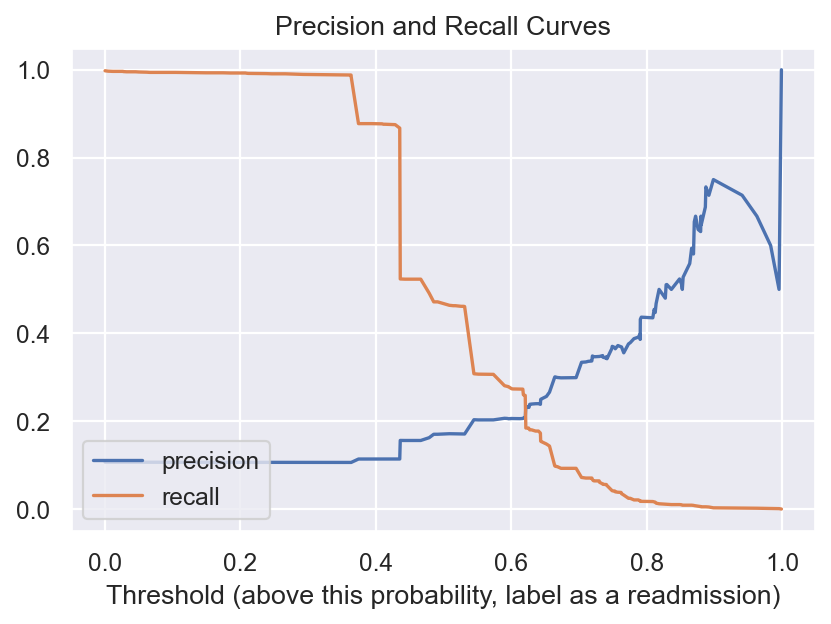

<Figure size 480x320 with 0 Axes>

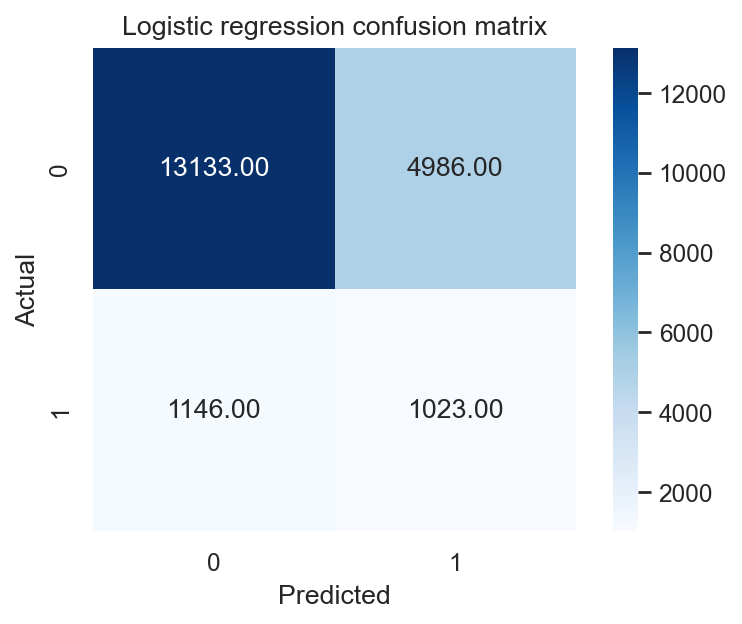

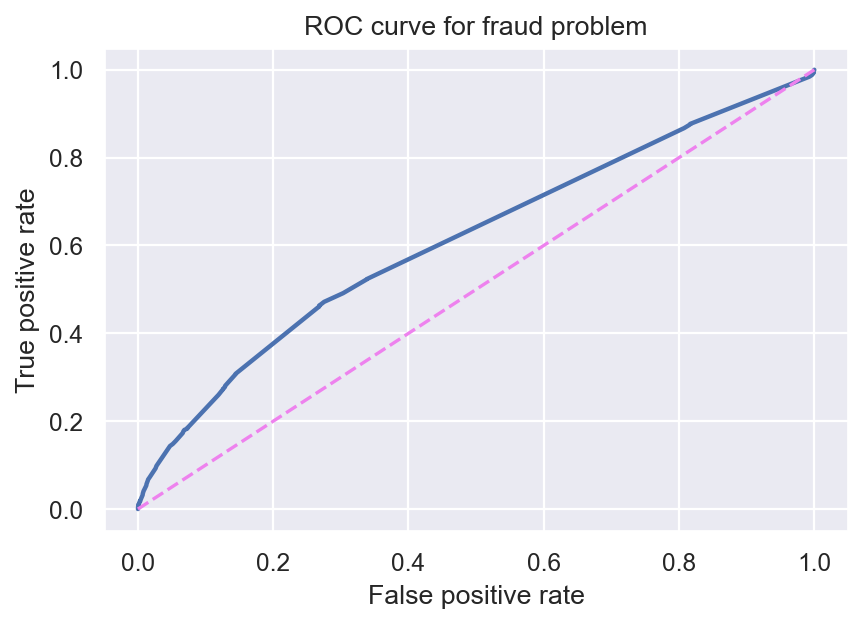

In [767]:
features_best = ['number_inpatient','number_emergency','diag_3_Other'] # BEST !!!!!!
forest_balanced_model = RandomForestClassifier(n_estimators = 300, random_state = 0, class_weight ='balanced')
RF_benchmark_model = testing_models(forest_balanced,features_best)

20288
F1 training all: 0.9445
F1 test: 0.0477
ROC-AUC: 0.5942


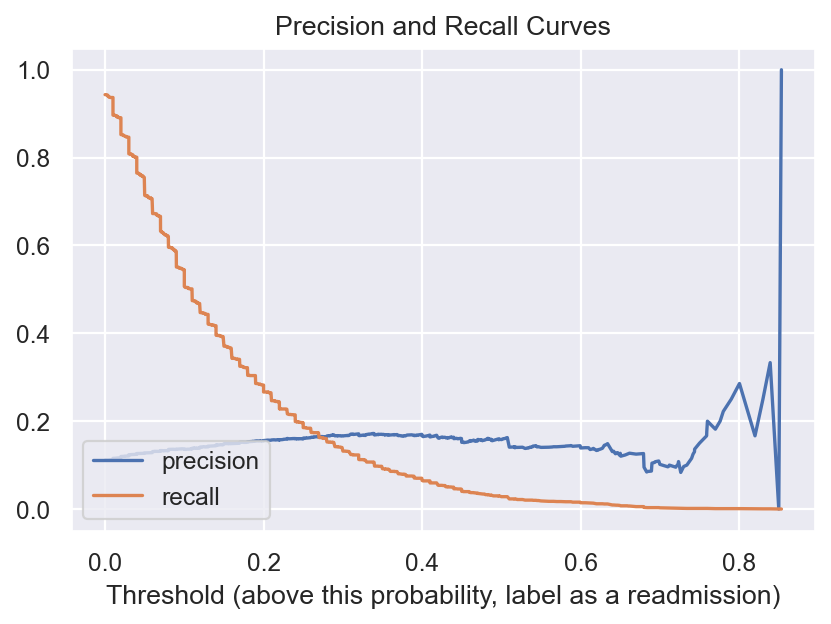

<Figure size 480x320 with 0 Axes>

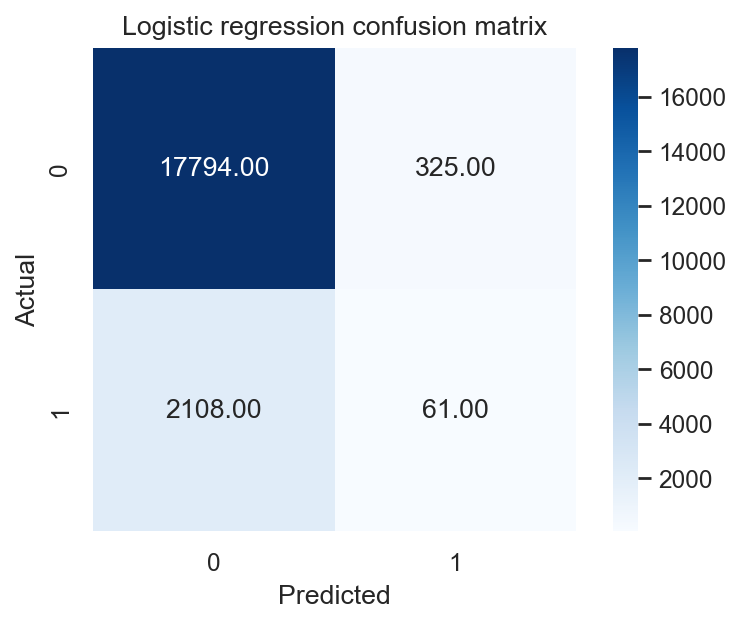

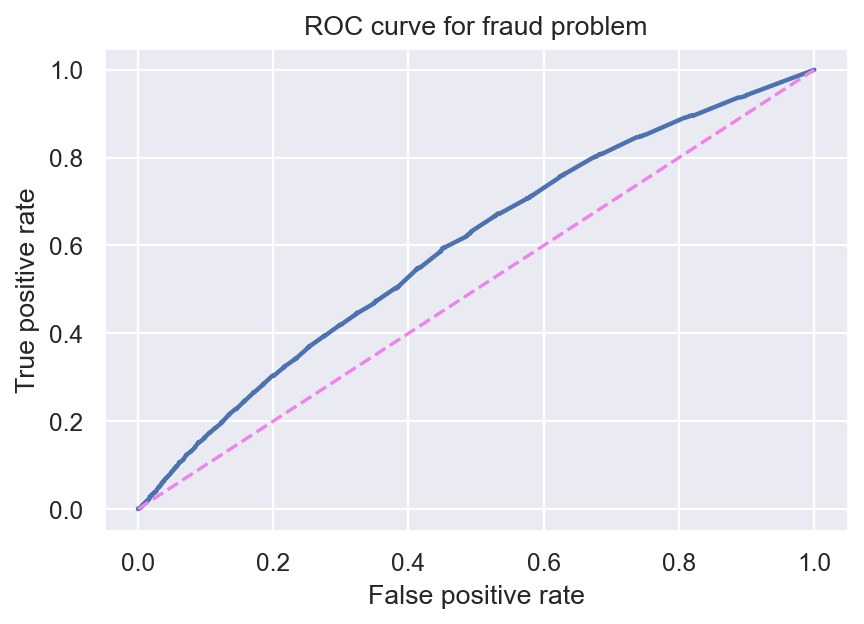

In [786]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses'] # with CV
forest_baseline_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
RF_baseline_model = testing_models(forest_baseline_model,features_all_numerical) 

In [773]:
def testing_LR(model,features_model):

    X_train = np.array(training_validation_set_catUpdated[features_model])
    y_train = np.array(training_validation_set_catUpdated[target])
    
    X_test = np.array(test_set_catUpdated[features_model])
    y_test = np.array(test_set_catUpdated[target])
        
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    model.fit(X_train, y_train.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
              
    print(f'F1 training all: {f1_score(y_train, model.predict(X_train)).round(4)}')
    print(f'F1 test: {f1_score(y_test, model.predict(X_test)).round(4)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]).round(4)}')

    # Recall-Precision curve
    plt.figure(dpi=80)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.xlim([0.0,1.05])
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');

    # Confusion matrix
    plt.figure(dpi=80)
    confusion = confusion_matrix(y_test, model.predict(X_test))
    plt.figure(dpi=80)
    # Print confusion matrix for RF
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');
    
    
    # ROC-AUC curve
    plt.figure(dpi=80)
    fpr1, tpr1, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr1, tpr1,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for fraud problem');
    
    return model



F1 training all: 0.2531
F1 test: 0.2538
ROC-AUC: 0.6226


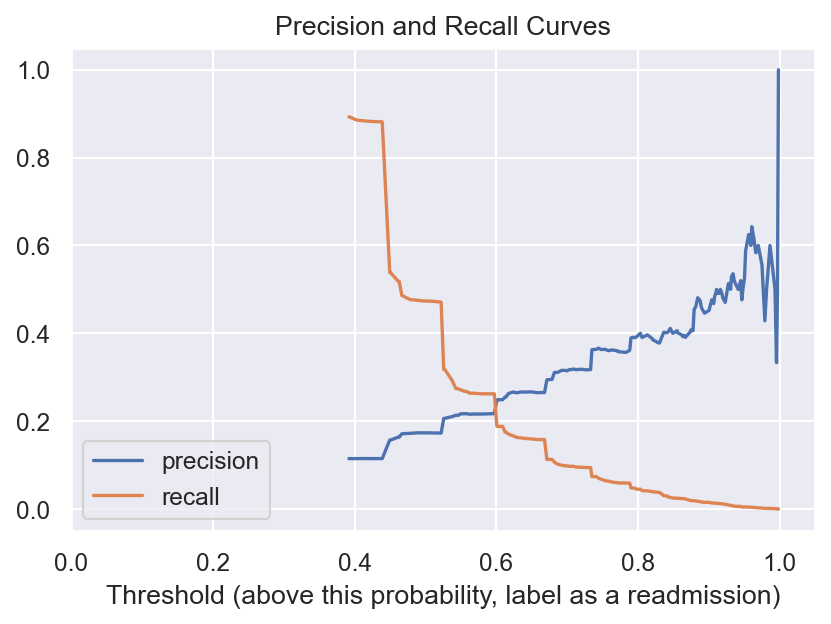

<Figure size 480x320 with 0 Axes>

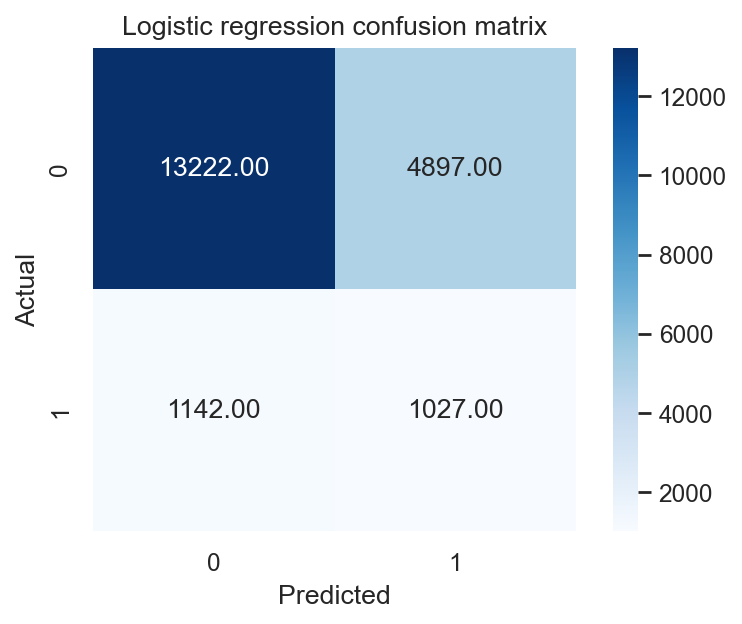

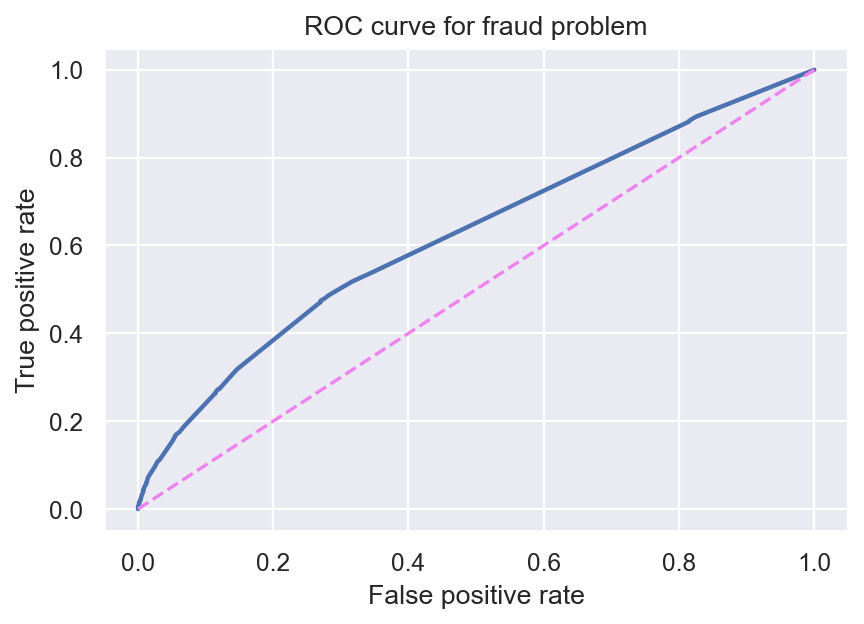

In [777]:
features_best = ['number_inpatient','number_emergency','diag_3_Other'] # BEST !!!!!!
lr_model = LogisticRegression(class_weight ='balanced')
LR_benchmark_model = testing_LR(lr_model,features_best)

F1 training all: 0.03
F1 test: 0.0225
ROC-AUC: 0.6369


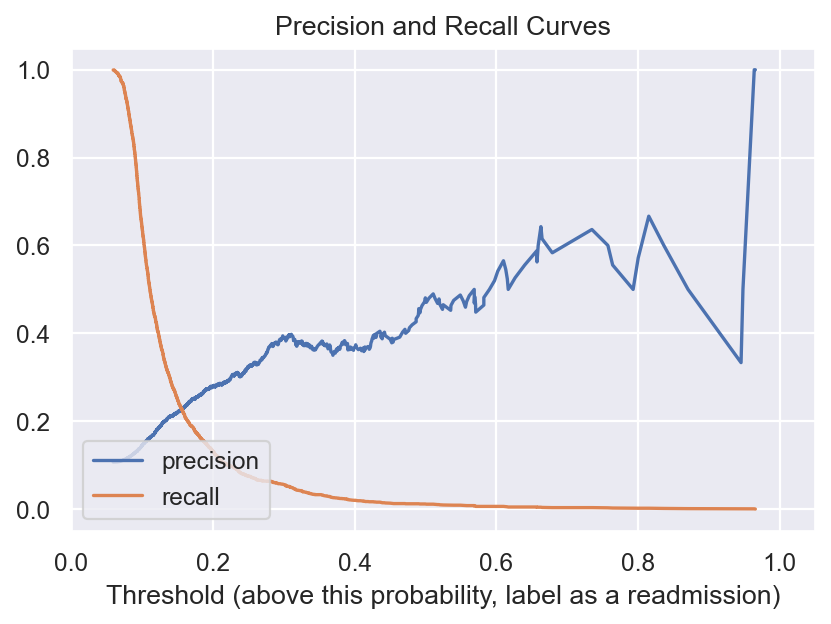

<Figure size 480x320 with 0 Axes>

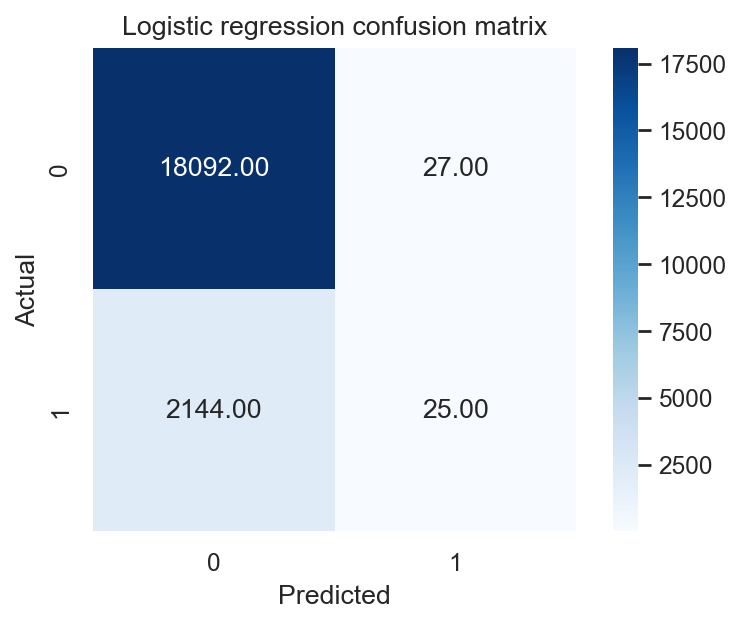

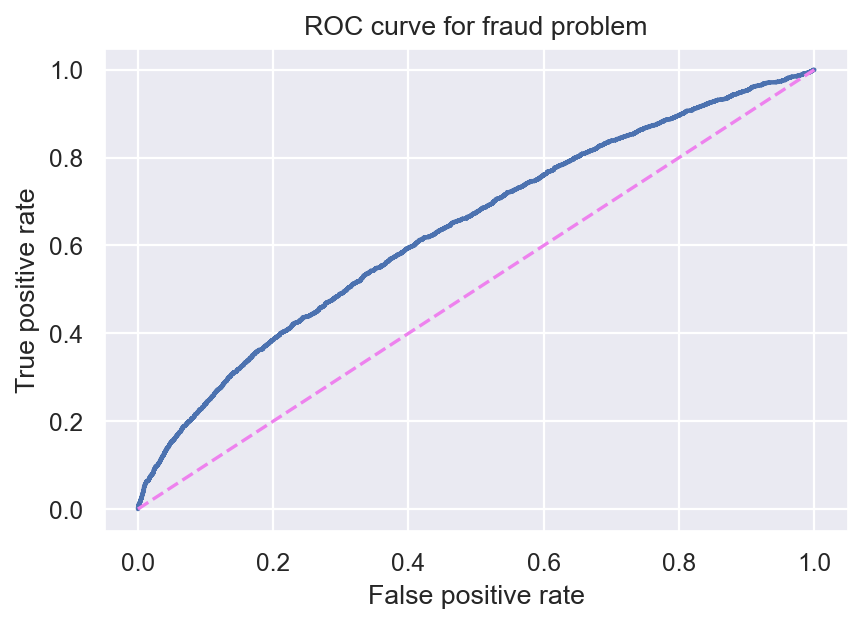

In [779]:

features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
baseline_model = LogisticRegression()
LR_baseline_model = testing_LR(baseline_model,features_all_numerical)


20288
F1 training all: 0.9372
F1 test: 0.0478
ROC-AUC: 0.5932


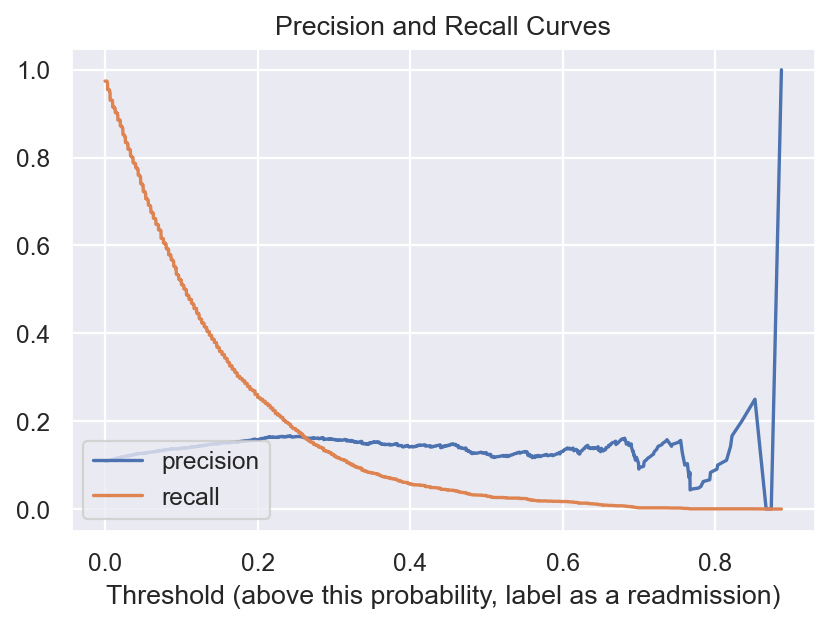

<Figure size 480x320 with 0 Axes>

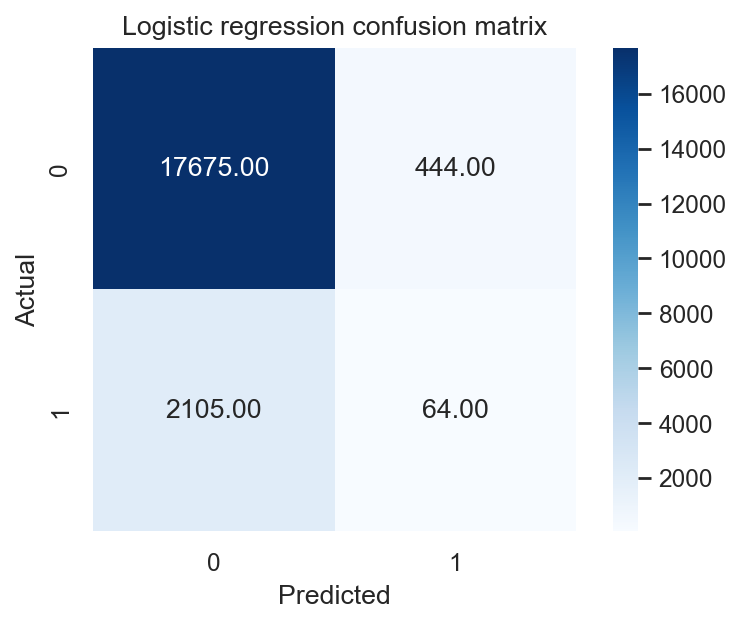

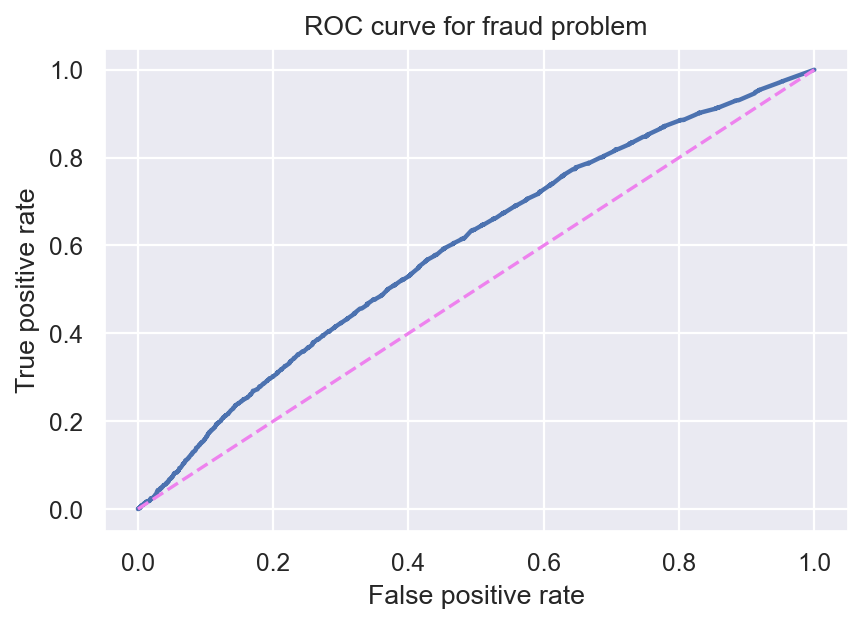

In [784]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses'] # BEST !!!!!!
forest_baseline = RandomForestClassifier(n_estimators = 300, random_state = 0, class_weight ='balanced')
RF_baseline = testing_models(forest_baseline,features_all_numerical)

In [760]:
(13113+1146+1023+4986)/(1023+4986)

3.3729405891163253

In [765]:
(13113+1146+1023+4986)/(1023+1146)*100

934.4398340248963

In [766]:
(1023+4986)/(1023+1146)*100

277.04011065006915

# XGBoost

In [715]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

NameError: name 'xgb' is not defined

In [ ]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

# Experimento que no ha funcionado demasiado

In [654]:
features_model = ['number_inpatient','number_emergency']  + list_dummy_variables + ['number_diagnoses'] + ['time_in_hospital'] # GOOD SO FAR AS WELL!

forest_all = random_forests_weightsBalanced_catUpdated(features_model) 

['number_inpatient', 'number_emergency', 'race_Caucasian', 'race_Other', 'gender_Male', 'gender_Other', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'weight_null_value', 'payer_code_MC', 'payer_code_Other', 'payer_code_null_value', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_InternalMedicine', 'medical_specialty_Other', 'medical_specialty_null_value', 'diag_1_428', 'diag_1_Other', 'diag_2_276', 'diag_2_428', 'diag_2_Other', 'diag_3_276', 'diag_3_401', 'diag_3_Other', 'max_glu_serum_Other', 'A1Cresult_None', 'A1Cresult_Other', 'metformin_Other', 'metformin_Steady', 'repaglinide_Other', 'nateglinide_Other', 'chlorpropamide_Other', 'glimepiride_Other', 'acetohexamide_Other', 'glipizide_Other', 'glipizide_Steady', 'glyburide_Other', 'glyburide_Steady', 'tolbutamide_Other', 'pioglitazone_Other', 'pioglitazone_Steady', 'rosiglitazone_Other', 'rosiglitazone_Steady', 'acarbose_Other', 'miglitol_Other', 'trog

In [ ]:
random_forests_weightsBalanced_catUpdated(features_model = pd.Series(features_model)

In [676]:
from matplotlib.pyplot import figure



In [679]:
def plot_feature_importance_RF(model,features_model):
    figure(figsize=(16, 12), dpi=80)
    n_features = len(features_model)
    plt.barh(np.arange(n_features),model.feature_importances_)
    plt.yticks(np.arange(n_features),features_model)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)

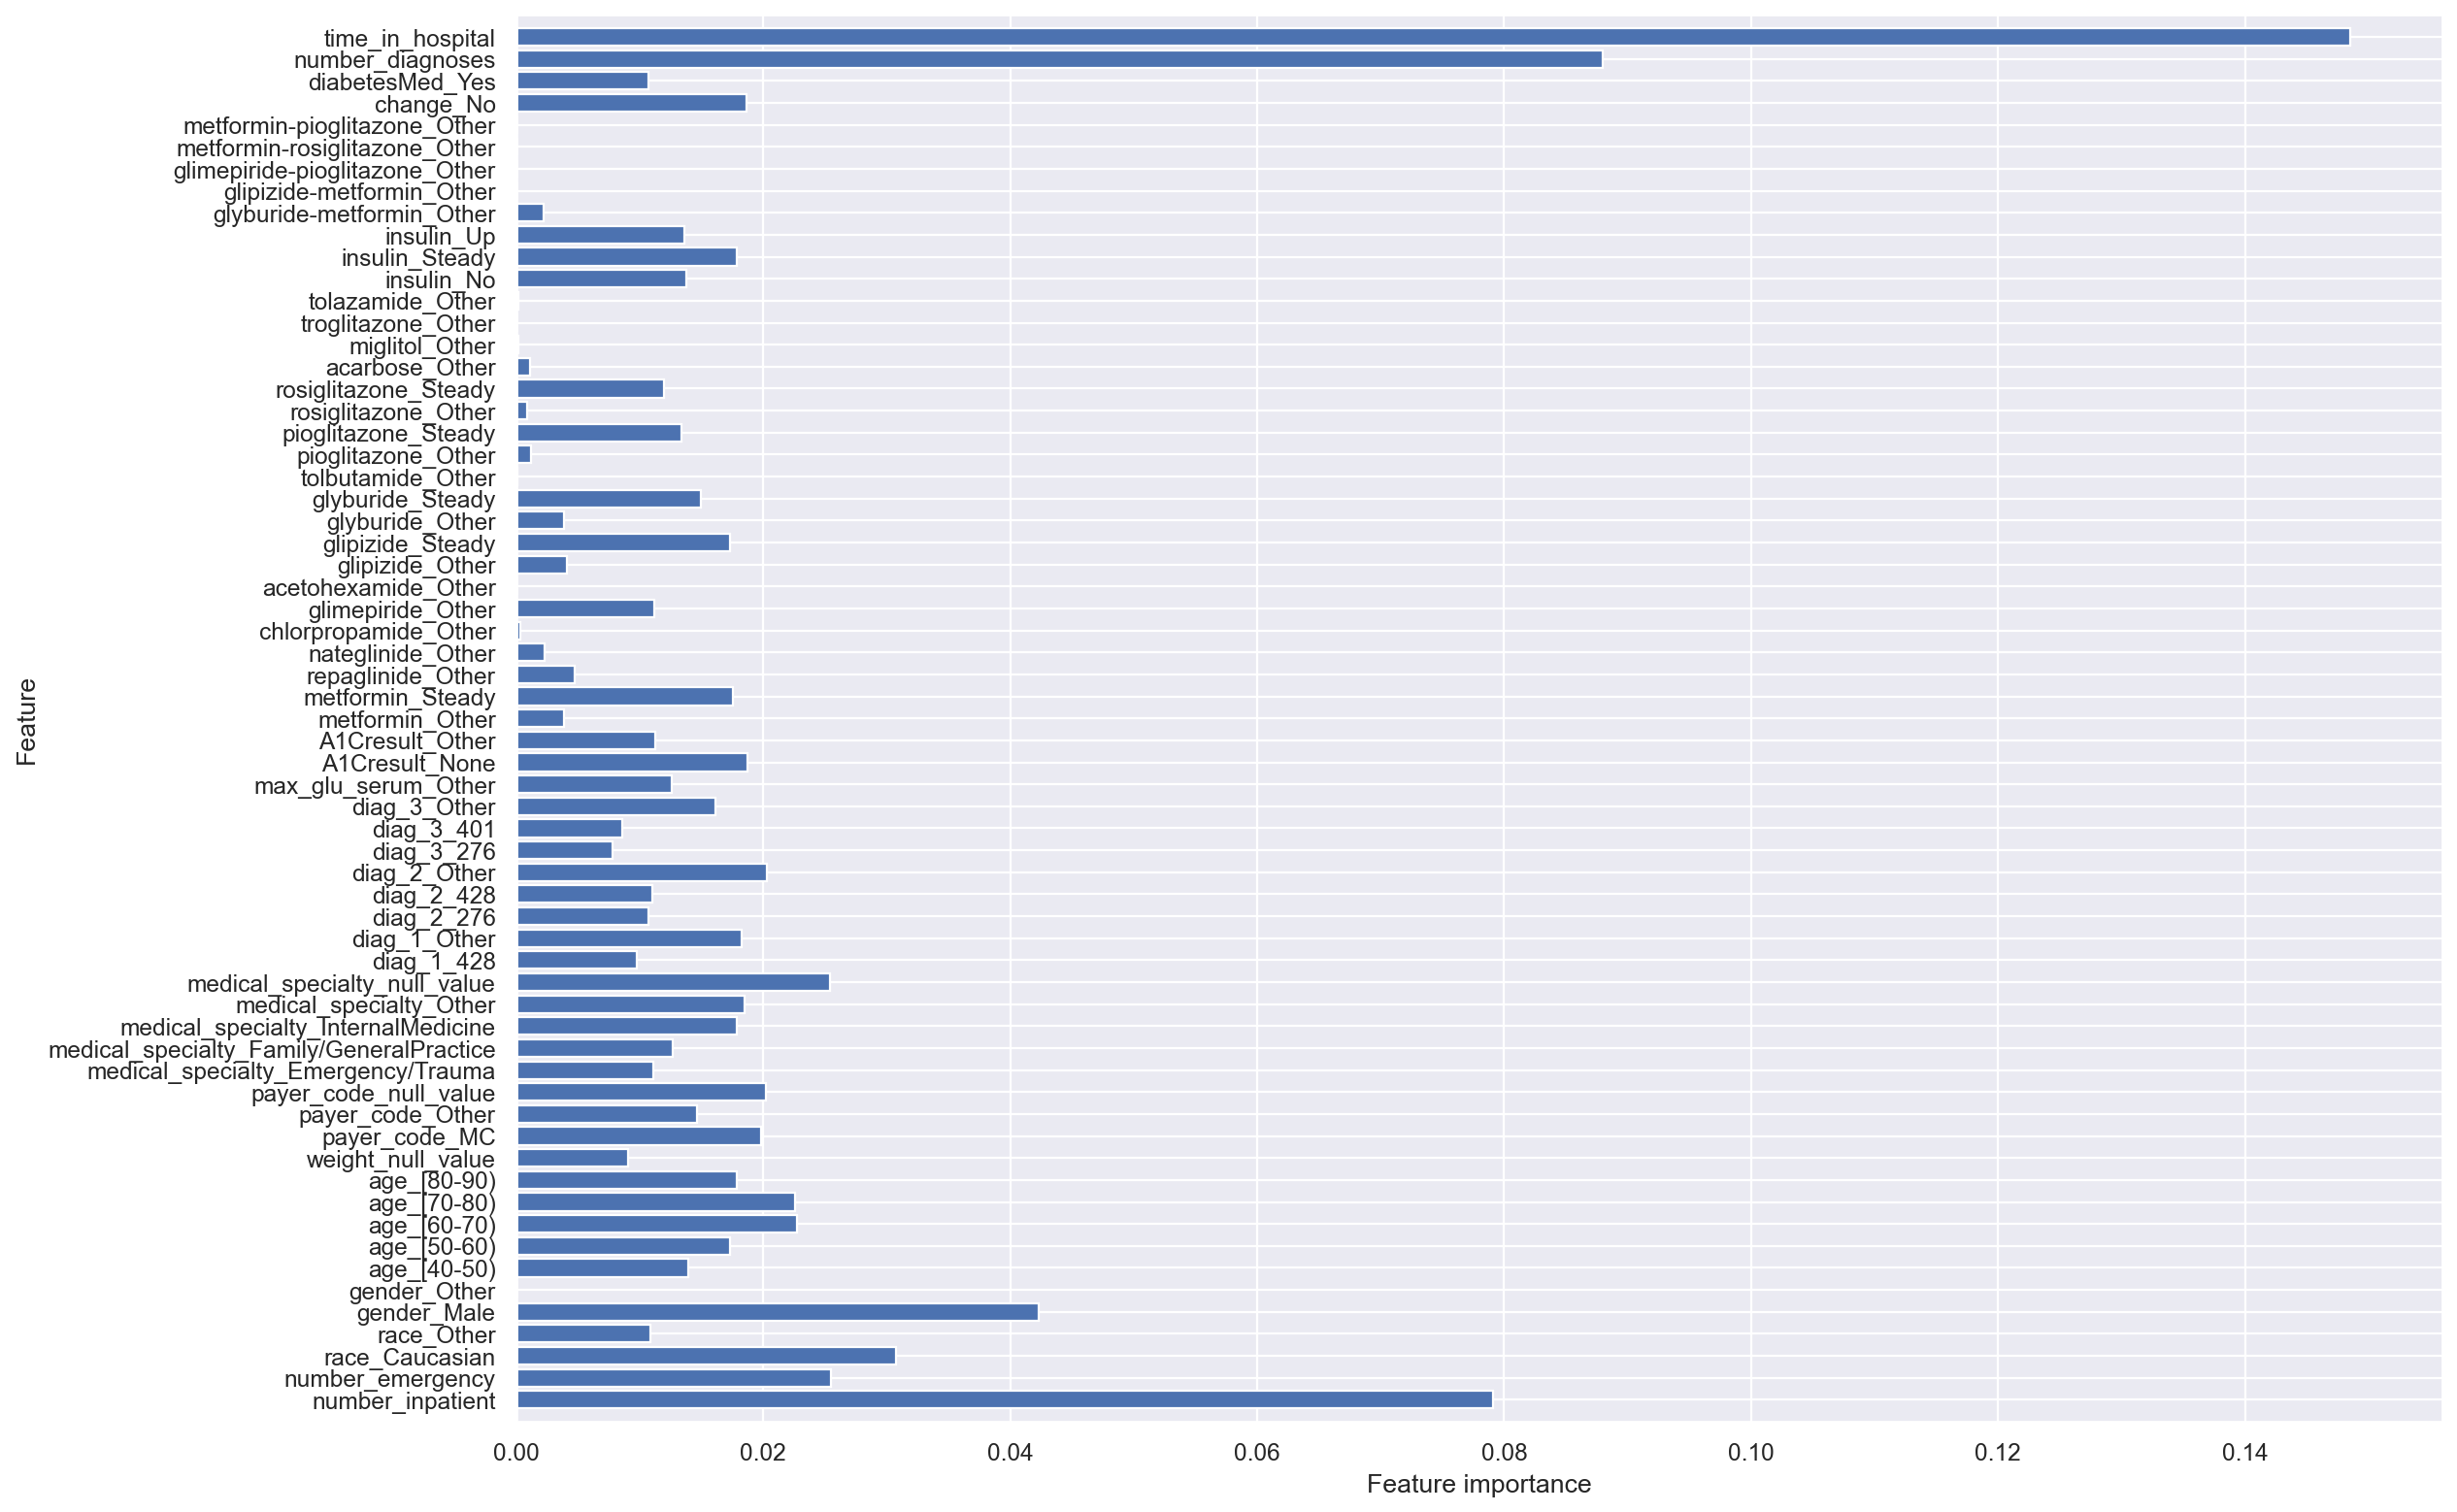

In [682]:
plot_feature_importance_RF(forest_all[0],features_model)

In [684]:
features_model = ['time_in_hospital','number_diagnoses','number_inpatient','gender_Male','race_Caucasian','number_emergency','age_[70-80)','age_[60-70)','diag_1_428']  # GOOD SO FAR AS WELL!

forest_all2 = random_forests_weightsBalanced_catUpdated(features_model) 

['time_in_hospital', 'number_diagnoses', 'number_inpatient', 'gender_Male', 'race_Caucasian', 'number_emergency', 'age_[70-80)', 'age_[60-70)', 'diag_1_428']
F1 training mean 10-fold cv: 0.366 +- 0.003
F1 validation mean 10-fold cv: 0.180 +- 0.010
ROC-AUC mean 10-fold cv: 0.518 +- 0.007


In [655]:
forest_all

RandomForestClassifier(class_weight='balanced', random_state=0)

In [635]:
features_model = ['number_inpatient','number_emergency','diag_3_Other']   # GOOD SO FAR AS WELL!
random_forests_weightsBalanced_catUpdated(features_model)
random_forests_weightsBalanced_catUpdated(features_model) 

['number_inpatient', 'number_emergency', 'diag_3_Other']
F1 training mean 10-fold cv: 0.255 +- 0.001
F1 validation mean 10-fold cv: 0.249 +- 0.011
ROC-AUC mean 10-fold cv: 0.608 +- 0.009
['number_inpatient', 'number_emergency', 'diag_3_Other']
F1 training mean 10-fold cv: 0.255 +- 0.001
F1 validation mean 10-fold cv: 0.249 +- 0.011
ROC-AUC mean 10-fold cv: 0.608 +- 0.009


In [596]:
def LR_weightsBalanced(features_all_numerical):

    X_train = np.array(training_validation_set_catUpdated[features_all_numerical])
    y_train = np.array(training_validation_set_catUpdated[target])

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
        
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        cv_F1_training.append(f1_score(y_train_fold, lr.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, lr.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, lr.predict_proba(X_val_fold)[:,1]).round(3))

        # Recall-Precision curve
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, lr.predict_proba(X_val_fold)[:,1])
        plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
        plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

        # Confusion matrix
        confusion = confusion_matrix(y_val_fold, lr.predict(X_val_fold))
        if ct ==1:
            confusion_final = confusion
        else:
            confusion_final +=confusion
        ct+=1


    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')

    plt.figure(dpi=80)
    # Print confusion matrix for logistic regression
    sns.heatmap(confusion_final, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');






# BEST LR so far!

F1 training mean 10-fold cv: 0.249 +- 0.001
F1 validation mean 10-fold cv: 0.248 +- 0.011
ROC-AUC mean 10-fold cv: 0.607 +- 0.013


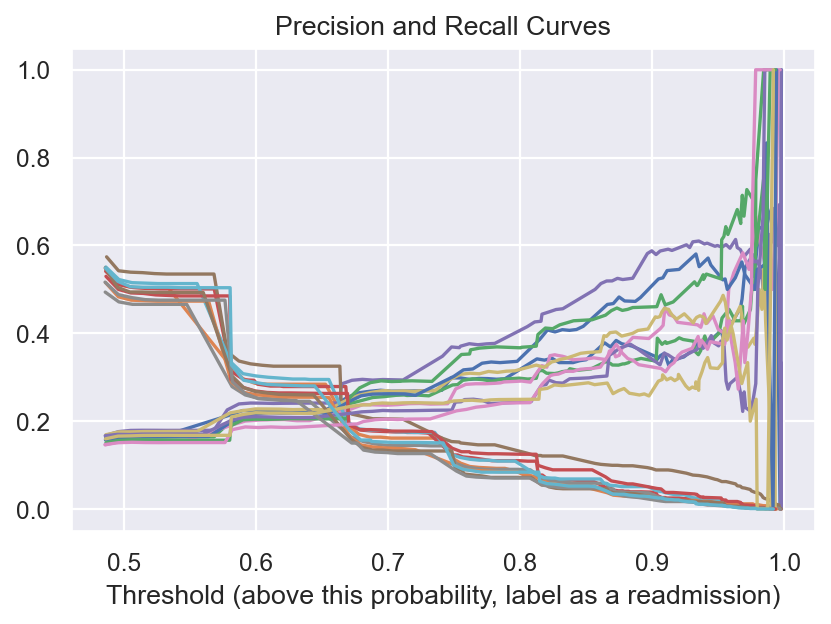

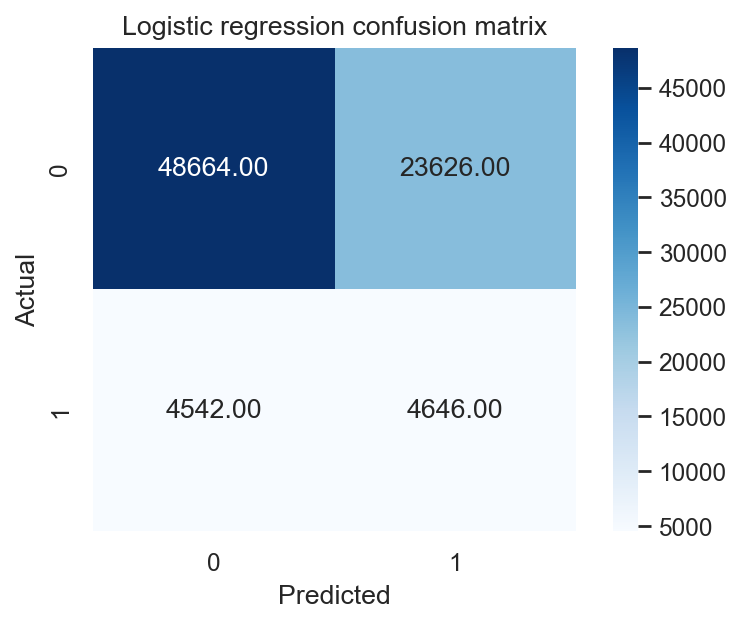

In [598]:
from sklearn.preprocessing import StandardScaler


features_model = ['number_inpatient','number_emergency']  # GOOD SO FAR AS WELL!
LR_weightsBalanced(features_model)

F1 training mean 10-fold cv: 0.845 +- 0.002
F1 validation mean 10-fold cv: 0.082 +- 0.014
ROC-AUC mean 10-fold cv: 0.539 +- 0.009


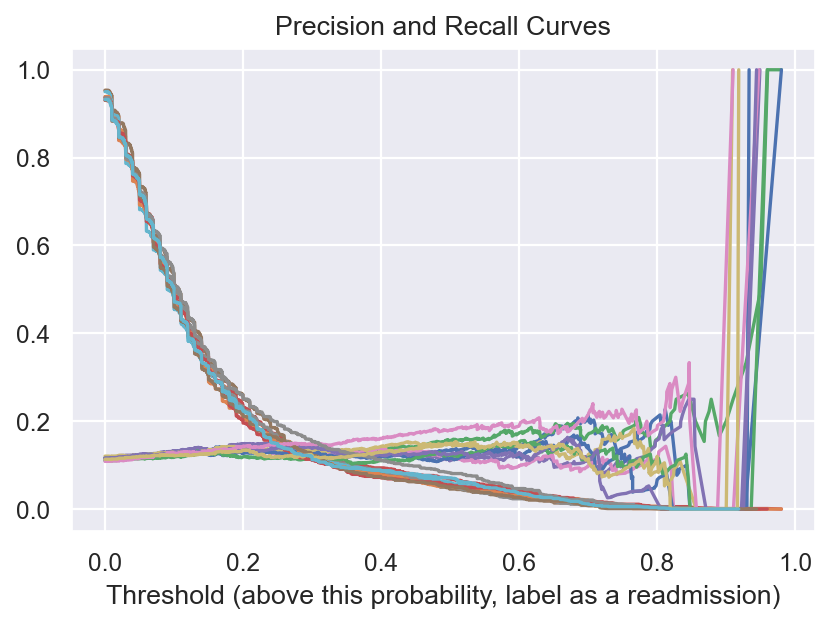

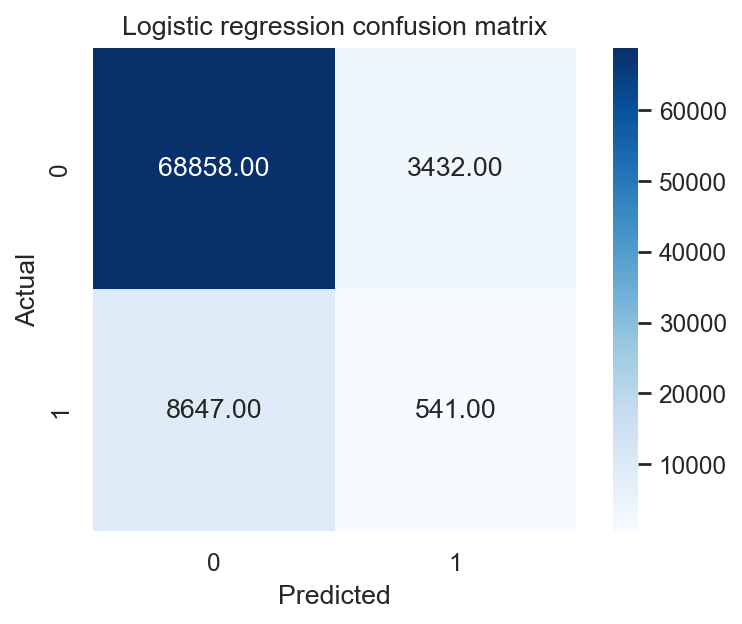

In [520]:
features_model = ['time_in_hospital','number_emergency'] + list_dummy_variables # GOOD SO FAR AS WELL!
LR_weightsBalanced(features_model)

In [466]:
diabetic_data2[column] = update_categorical_variable(column,diabetic_data2)

In [469]:
column!='race'

False

In [429]:
column = 'race'

In [460]:
    data = pd.DataFrame(diabetic_data2.groupby([column])['encounter_id'].count()).reset_index().rename(columns = {'encounter_id': 'count'}.copy())
    data['count'] = (data['count']/data['count'].sum()*100)
    data.rename(columns={'count':'percentage'},inplace = True)
    data.set_index(column,inplace=True)
    data
    
   

percentage
race                       
AfricanAmerican   18.876639
Asian              0.629876
Caucasian         74.778413
Hispanic           2.001651
Other              1.479866
null_value         2.233555

In [443]:
data.percentage['Asian'] < 5.0

True

In [457]:
diabetic_data2[column].fillna('null_value',inplace=True)

In [450]:
data.percentage[diabetic_data2['race'].iloc[0]] >= 5.0

True

In [461]:
 for i in range(len(diabetic_data2)):
        if data.percentage[diabetic_data2['race'].iloc[i]] < 5.0:
            diabetic_data2.at[i,'race']= 'Other'

In [463]:
diabetic_data2.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Other               6457
Name: race, dtype: int64

In [409]:
def groups_fewer5a(row):
    if data.loc[row] <= 5.0:
        return 'Other'
    else:
        return row

In [424]:
def update_categorical_variable(column,diabetic_data2):
    
    data = pd.DataFrame(diabetic_data.groupby([column])['encounter_id'].count()).reset_index().rename(columns = {'encounter_id': 'count'}.copy())
    data['count'] = (data['count']/data['count'].sum()*100)
    data.rename(columns={'count':'percentage'},inplace = True)
    data.set_index(column,inplace=True)
    
    for i in range(len(diabetic_data2)):
        if data[diabetic_data2[column].iloc[i] < 5.0:
           diabetic_data2.at[i,column]= 'Other'
    
    return diabetic_data2
    



SyntaxError: invalid syntax (3462878626.py, line 10)

In [425]:
diabetic_data2[column] =update_categorical_variable('race',diabetic_data2)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [421]:
data = pd.DataFrame(diabetic_data.groupby(['race'])['encounter_id'].count()).reset_index().rename(columns = {'encounter_id': 'count'}.copy())
data['count'] = (data['count']/data['count'].sum()*100)
data.rename(columns={'count':'percentage'},inplace = True)
data.set_index('race',inplace=True)
type(data)

pandas.core.frame.DataFrame

In [398]:
data.loc['AfricanAmerican'].percentage


19.30789100740756

In [369]:
data = pd.DataFrame(data.apply(lambda x: x['race'] if x.percentage >= 5.0 else 'Other', axis=1))
data

AttributeError: 'Series' object has no attribute 'percentage'

In [ ]:
def create_othewise_category(row):
    

In [317]:
for column in columns:
    if dtype(diabetic_data[column]) == 'object':
        diabetic_data[column].
        
        data = diabetic_data.groupby([column])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()


race
gender
age
weight
payer_code
medical_specialty
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


In [ ]:
diabetic_data[

In [114]:
def plots_precision_recall_curve(model,X_val,y_val):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1])
    plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as fraud)');
    plt.title('Precision and Recall Curves');

In [107]:


for train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):
    print(8000 in train_ind,  8000 in val_ind)
    
    X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]

    X_val, y_val = X_train[val_ind], y_train[val_ind] 
    
    forest_balanced2 = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
    forest_balanced2.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
    print(f1_score(y_train_fold, forest_balanced2.predict(X_train_fold)),roc_auc_score(y_train_fold, forest_balanced2.predict_proba(X_train_fold)[:,1])) # Because we are working with imbalanced data.
    print(f1_score(y_val, forest_balanced2.predict(X_val)),roc_auc_score(y_val, forest_balanced2.predict_proba(X_val)[:,1])) # Because we are working with imbalanced data.

    
    # lr = LogisticRegression(solver='lbfgs')
    # lr.fit(X_train_fold, y_train_fold)
    # print(lr.score(X_val, y_val)) # Because we are working with imbalanced data.

    
    
    # print(f1_score(lr.predict(X_val), y_val)) # Because we are working with imbalanced data.
    

False True
0.9427962440232733 0.9976811060055911
0.04409171075837742 0.5757793232451404
True False
0.9415150817407323 0.997665267073534
0.05067873303167421 0.5746514490592525
True False
0.9423388028657268 0.9977074017272248
0.04035087719298246 0.5787797959550852
True False
0.9427702198496067 0.9976660821551069
0.038387715930902115 0.5629116410741929
True False
0.943505777158451 0.9976982454160221
0.04729729729729729 0.5764580247843296
True False
0.942840713053479 0.9977396848077338
0.05077062556663645 0.5783948560354535
True False
0.9421052631578948 0.9977474558781184
0.037209302325581395 0.5658138413356912
True False
0.9427877947295423 0.9976742287715054
0.042590949423247565 0.5643432217525186
True False
0.941358024691358 0.9975672798587071
0.03515263644773358 0.5662936743048593
True False
0.9413992997761579 0.9976864669656631
0.030797101449275364 0.5858181368740197


###  All numerical features: cross validation / 10-fold CV / imbalancing: weighting at training + lower threshold

###  Add categorical features, all of them: cross validation / 10-fold CV / imbalancing: weighting at training + lower threshold